## Import

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px 

from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
import math
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Les fonctions

In [2]:
# fonction pour visualiser les caractéristiques du fichier
def caracteristiquesFichier(fichier):
    DataFrame = pd.read_csv(fichier,sep=',')     # Lecture du fichier csv
    DataFrame.describe()
    display(DataFrame)
    print(DataFrame.shape)
    print(DataFrame.dtypes)
    print(f'La moyenne de valeurs manquantes est de : {DataFrame.isna().mean()}')
    return DataFrame

# function pour afficher les occurrences par indicateurs
def occurrenceVisualization(dataframe):
    dfCount = dataframe.value_counts().reset_index().values.tolist() 
    dfCount_colonne = np.array(dfCount)
    print(f"Dataframe : {dataframe}")
    print(tabulate(dfCount_colonne, headers=["Valeur unique", "Nombre d'occurrences"], tablefmt="grid"))

# fonction pour visualiser le taux de remplissage
def PlotTauxDeRemplissage(dataframe, figureName, colorBar="seagreen",sort=None):
    plt.figure()
    plt.title('Taux de remplissage par indicateur',fontsize=15) #titre
    msno.bar(dataframe,fontsize=12, color=colorBar,sort=sort) # taux de remplissage
    plt.tight_layout()      # pour que rien ne sorte du format de l'image
    plt.savefig(figureName) #sauvegarde de la figure
    plt.show()


# fonction pour calculer le nombre de doublons et les supprimer
def areThereDuplicates(dataframe, subset=['Country Code', 'Short Name']):

    nombre_doublons_sc = dataframe.duplicated(subset=subset).sum()
    print("Nombre de doublons dans le DataFrame :", nombre_doublons_sc)

    if nombre_doublons_sc>0:
        dataframe.drop_duplicates(subset=subset, inplace=True)
        print("--- suppression des doublons --- ")  

    return dataframe


def cleanFile(dataframe, seuil, colonnes_a_ignorer=None):
# Seuil entre 0 et 1
    # Calcul du nombre moyen de NaN dans chaque colonne
    pourcentage_nan = dataframe.isna().mean()
    colonnes_vides = pourcentage_nan[pourcentage_nan >= seuil].index.tolist()
    nbEmptyCol = len(colonnes_vides)

    if nbEmptyCol == 1:
        print(f"Il y a {nbEmptyCol} colonne vide, qui est : {colonnes_vides[0]}")
        dataframe.drop(colonnes_vides[0], axis=1, inplace=True)  # Suppression de la colonne vide
        print(f"--- suppression de la colonne vide à plus de {seuil:0.1%} --- ")
    elif nbEmptyCol == 0:
        print(f"Il n'y a pas de colonnes vides à plus de {seuil:0.1%}")
    else:
        print(f"Il y a {nbEmptyCol} colonnes vides, qui sont : {', '.join(colonnes_vides)}")
        dataframe.drop(colonnes_vides, axis=1, inplace=True)  # Suppression des colonnes vides
        print(f"--- suppression des {nbEmptyCol} colonnes vides à plus de {seuil:0.1%}--- ")
    
    return dataframe

# Remplacer les valeurs négatives par des NaN
def remplacer_valeurs_negatives(dataframe: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    df = dataframe.copy()
    for col in columns:
        df.loc[:,col] = dataframe[col].fillna(method="ffill").where(dataframe[col] >= 0)
    return df

# Remplacer les valeurs abérrantes par des NaN
def remplacer_valeurs_abrérrantes(dataframe: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    
    df = dataframe.copy()
    Q = df[columns].quantile([0.25, 0.75])
    iqr = Q.loc[0.75]-Q.loc[0.25]
    limits = pd.DataFrame({
        col: [
            Q.loc[0.25, col] - 1.5 * iqr[col], # min
            Q.loc[0.75, col] + 1.5 * iqr[col], # max
        ] for col in columns
    }, index=['min', 'max'])
    #Remplir par des Nans si en dehors de l'intervalle 
    for col in columns:
        df.loc[:,col] = dataframe[col].where(
            limits.loc['min', col] <= dataframe[col]
        ).where(
            dataframe[col] <= limits.loc['max', col]
        )

    return df

def plot_valeurs_manquantes(dataframe: pd.DataFrame, figureName) -> None:
    num_rows = len(dataframe)
    
    # Calcul du nombre et du pourcentage de valeurs manquantes par colonne
    missing_values_info = pd.DataFrame({
        'Variable': dataframe.columns,
        'Nombre de valeurs manquantes': dataframe.isna().sum(),
        '% de valeurs manquantes': 100 * dataframe.isna().sum() / num_rows
    }).sort_values(by='Nombre de valeurs manquantes')

    # Création du graphique à barres avec une couleur spécifique
    fig = px.bar(
        missing_values_info,
        x='Variable',
        y='% de valeurs manquantes',
        color='% de valeurs manquantes',  # Utilisation du pourcentage pour déterminer la couleur
        labels={
            'Variable': 'Variables',
            '% de valeurs manquantes': '% de valeurs manquantes',
            'Nombre de valeurs manquantes': '# valeurs manquantes'
        },
        hover_data=['Nombre de valeurs manquantes'],
        title='Valeurs manquantes par colonne',
        width=1200,
        height=600
    )
    plt.tight_layout()
    fig.show()
    plt.savefig(figureName) #sauvegarde de la figure

def traitementNAN(df, colonne_cible, colonnes_data):
    # Affichage du pourcentage de valeurs manquantes dans la colonne cible
    pourcentage_manquantes = df[colonne_cible].isna().mean() * 100
    print(f"La colonne {colonne_cible} a {pourcentage_manquantes:.2f}% de valeurs manquantes à traiter")

    # Création d'un DataFrame avec les colonnes de données et la colonne cible
    colonnes_total = colonnes_data + [colonne_cible]
    dataSamp = df.dropna(subset=colonnes_total).sample(n=10000, random_state=42)

    # Séparation des données et de la cible
    data = dataSamp[colonnes_data]
    cible = dataSamp[colonne_cible]

    # Division des données en ensembles d'entraînement et de test
    xtrain, xtest, ytrain, ytest = train_test_split(data, cible, train_size=0.8)

    # Entraînement d'un modèle KNN
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(xtrain, ytrain)

    # Évaluation de la précision du modèle
    score_R2 = knn.score(xtest, ytest)
    print(f"\tScore R^2 : {score_R2:.2f}")

    # Prédiction des valeurs manquantes dans la colonne cible et retour
    return knn.predict(df[colonnes_data].fillna(value=0))

def detect_outliers_iqr(data, column): 
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound)| (data[column] > upper_bound)]

In [3]:

df = caracteristiquesFichier("Donnees_Building_Energy.csv")

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

(3376, 46)
OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64


## Exploration

### Premiere exploration

In [4]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [5]:
df.shape

(3376, 46)

In [6]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [7]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [8]:
df.duplicated().sum()

0

In [9]:
plot_valeurs_manquantes(df, 'plotvaleursmanquantes.png')

<Figure size 640x480 with 0 Axes>

Pas de valeurs dupliqué

### Supression des premieres colonnes

In [10]:
pd.set_option('display.max_columns', None)
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


Je vais supprimer les colonnes qui ne servent à rien. 
- Data year (1 seul date)
- City (1 seul ville)
- State
- CouncilDistrictCode
- Comments

In [11]:
df['City'].value_counts()

City
Seattle    3376
Name: count, dtype: int64

In [12]:
df['State'].value_counts()

State
WA    3376
Name: count, dtype: int64

In [13]:
df['DataYear'].value_counts()

DataYear
2016    3376
Name: count, dtype: int64

In [14]:
df['Comments'].value_counts()

Series([], Name: count, dtype: int64)

In [15]:
df['CouncilDistrictCode'].value_counts()

CouncilDistrictCode
7    1037
3     596
2     509
4     367
5     338
1     282
6     247
Name: count, dtype: int64

In [16]:
df.drop(['City','State','Comments','CouncilDistrictCode'], axis=1, inplace=True)

In [17]:
df.shape

(3376, 42)

### Analyse et supression des colonnes pas essentiels

In [18]:
df['PropertyName'].value_counts()

PropertyName
Northgate Plaza                3
Canal Building                 2
Jefferson Court Apartments     2
Bayview Building               2
Crestview Apartments           2
                              ..
The Hathaway Building          1
Building R                     1
Building Q                     1
Orcas Maintenance Shop         1
Van Asselt Community Center    1
Name: count, Length: 3362, dtype: int64

In [19]:
df['Address'].value_counts()

Address
2600 SW Barton St              4
2203 Airport Way S             4
309 South Cloverdale Street    4
516 1st Ave W                  2
201 Thomas St.                 2
                              ..
655 South Orcas Street         1
661 South Orcas Street         1
4000 aurora ave n              1
3316 Fuhrman Ave E             1
2820 S Myrtle St               1
Name: count, Length: 3354, dtype: int64

In [20]:
df['ZipCode'].value_counts()

ZipCode
98109.0    294
98104.0    251
98122.0    243
98101.0    230
98105.0    191
98121.0    186
98134.0    186
98102.0    169
98119.0    167
98103.0    161
98125.0    152
98108.0    129
98115.0    129
98133.0    124
98107.0    101
98144.0     99
98116.0     93
98118.0     85
98199.0     70
98112.0     68
98126.0     64
98106.0     50
98117.0     31
98136.0     28
98195.0     10
98146.0      6
98178.0      4
98155.0      4
98111.0      3
98154.0      2
98013.0      2
98124.0      2
98168.0      2
98164.0      2
98177.0      2
98040.0      1
98020.0      1
98204.0      1
98272.0      1
98127.0      1
98113.0      1
98198.0      1
98011.0      1
98165.0      1
98006.0      1
98114.0      1
98028.0      1
98012.0      1
98053.0      1
98181.0      1
98185.0      1
98191.0      1
98033.0      1
98070.0      1
98145.0      1
Name: count, dtype: int64

In [21]:
df['TaxParcelIdentificationNumber'].value_counts()

TaxParcelIdentificationNumber
1625049001    8
3224049012    5
0925049346    5
0002400002    5
3624039009    4
             ..
1972202635    1
1977200970    1
1977201050    1
1977201055    1
7857002030    1
Name: count, Length: 3268, dtype: int64

In [22]:
df['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: count, dtype: int64

In [23]:
print(df.isnull().sum())

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
ZipCode                              16
TaxParcelIdentificationNumber         0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697
ThirdLargestPropertyUseType        2780
ThirdLargestPropertyUseTypeGFA     2780
YearsENERGYSTARCertified           3257


In [24]:
df.drop(['PropertyName','Address','ZipCode','TaxParcelIdentificationNumber','ListOfAllPropertyUseTypes','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','Electricity(kWh)','NaturalGas(therms)'], axis=1, inplace=True)

Suppression des colonnes qui ne m'intéressent pas pour l'étude

In [25]:
df.shape

(3376, 33)

### Suppression des valeurs négatives

In [26]:
colonne_negatives = ['OSEBuildingID','YearBuilt','NumberofBuildings','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','ENERGYSTARScore','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']
df[colonne_negatives].describe()

,OSEBuildingID,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.000000,3368.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3367.000000,3.371000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,1968.573164,1.106888,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,134.232848,5.403667e+06,2.745959e+05,3.707612e+06,1.368505e+06,119.723971,1.175916
std,12223.757015,33.088156,2.108402,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,139.287554,2.161063e+07,3.912173e+06,1.485066e+07,6.709781e+06,538.832227,1.821452
min,1.000000,1900.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,1948.000000,1.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,74.699997,9.251286e+05,0.000000e+00,6.394870e+05,0.000000e+00,9.495000,0.210000
50%,23112.000000,1975.000000,1.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,96.199997,1.803753e+06,0.000000e+00,1.177583e+06,3.237540e+05,33.920000,0.610000
75%,25994.250000,1997.000000,1.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,143.899994,4.222455e+06,0.000000e+00,2.829632e+06,1.189034e+06,93.940000,1.370000
max,50226.000000,2015.000000,111.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


In [27]:
for var in colonne_negatives :
    df.drop(df.loc[(df[var]<0),:].index, inplace=True)

In [28]:
df.describe()

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3375.000000,3375.0,3375.000000,3375.000000,3375.000000,3367.000000,3375.000000,3.375000e+03,3375.000000,3.375000e+03,3.355000e+03,1679.000000,596.000000,2532.000000,3368.000000,3369.000000,3366.000000,3.370000e+03,3.366000e+03,3.366000e+03,3.366000e+03,3366.000000,3366.000000
mean,21200.524444,2016.0,47.624036,-122.334802,1968.560000,1.106920,4.708741,9.484623e+04,8003.896889,8.684233e+04,7.918688e+04,28444.075817,11738.675166,67.906003,54.746259,57.049243,134.272133,5.405169e+06,2.746775e+05,3.708748e+06,1.368911e+06,119.759777,1.176272
std,12215.663829,0.0,0.047765,0.027205,33.084217,2.108714,5.495234,2.188688e+05,32331.220592,2.079698e+05,2.017328e+05,54392.917928,29331.199286,26.871011,56.275492,57.164783,139.289592,2.161366e+07,3.912752e+06,1.485272e+07,6.710736e+06,538.908278,1.821606
min,1.000000,2016.0,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,19990.500000,2016.0,47.599860,-122.350665,1948.000000,1.000000,2.000000,2.848200e+04,0.000000,2.775200e+04,2.509350e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,9.255353e+05,0.000000e+00,6.396010e+05,0.000000e+00,9.502500,0.210000
50%,23111.000000,2016.0,47.618680,-122.332500,1975.000000,1.000000,4.000000,4.416200e+04,0.000000,4.321000e+04,3.988800e+04,10664.000000,5043.000000,75.000000,38.650000,40.900002,96.199997,1.804446e+06,0.000000e+00,1.177658e+06,3.242570e+05,33.960000,0.615000
75%,25993.000000,2016.0,47.657120,-122.319445,1997.000000,1.000000,5.000000,9.102500e+04,0.000000,8.431250e+04,7.629550e+04,26640.000000,10138.750000,90.000000,60.400002,64.300003,143.899994,4.223664e+06,0.000000e+00,2.830153e+06,1.189321e+06,93.975000,1.370000
max,50226.000000,2016.0,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


### BuildingType

In [29]:
df['BuildingType'].value_counts()

BuildingType
NonResidential          1459
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [30]:
non_residentiel = ['NonResidential', 'Nonresidential COS', 'Nonresidential WA', 'SPS-District K-12', 'Campus']
df = df[df['BuildingType'].isin(non_residentiel)]
df['BuildingType'].value_counts()

BuildingType
NonResidential        1459
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64

J'ai gardé seulement les batiments non résidentiels

In [31]:
df.shape

(1667, 33)

### ComplianceStatus

In [32]:
df['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       1547
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: count, dtype: int64

In [33]:
df[df['ComplianceStatus'] == 'Missing Data']


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
28,34,2016,SPS-District K-12,K-12 School,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Missing Data,NaN,0.00,0.00
31,37,2016,SPS-District K-12,K-12 School,MAGNOLIA / QUEEN ANNE,47.63290,-122.35172,1989,1.0,2,51582,0,51582,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1496816.0,0.0,False,Missing Data,NaN,10.43,0.20
62,87,2016,SPS-District K-12,K-12 School,SOUTHWEST,47.50970,-122.37759,1948,1.0,2,53352,0,53352,K-12 School,65568.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,600813.0,0.0,False,Missing Data,NaN,4.19,0.08
81,118,2016,SPS-District K-12,K-12 School,DELRIDGE,47.56360,-122.35800,1999,1.0,3,74468,0,74468,K-12 School,75364.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1698176.0,0.0,False,Missing Data,NaN,11.84,0.16
85,122,2016,SPS-District K-12,K-12 School,SOUTHEAST,47.57324,-122.29058,1991,1.0,2,58933,0,58933,K-12 School,60725.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2347138.0,0.0,False,Missing Data,NaN,16.36,0.28
95,140,2016,SPS-District K-12,K-12 School,LAKE UNION,47.65464,-122.34912,1991,1.0,3,66588,0,66588,K-12 School,66588.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2104286.0,0.0,False,Missing Data,NaN,14.67,0.22
133,217,2016,SPS-District K-12,K-12 School,BALLARD,47.69675,-122.37760,1959,1.0,1,160270,0,160270,K-12 School,160270.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,4318917.0,False,Missing Data,NaN,229.38,1.43
139,227,2016,SPS-District K-12,K-12 School,CENTRAL,47.59796,-122.30415,1963,1.0,3,136188,0,136188,K-12 School,136188.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3217877.0,False,Missing Data,NaN,170.90,1.25
152,242,2016,SPS-District K-12,K-12 School,NORTH,47.69823,-122.32126,1989,1.0,2,52792,0,52792,K-12 School,55480.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Missing Data,NaN,0.00,0.00
614,820,2016,SPS-District K-12,K-12 School,CENTRAL,47.60120,-122.31548,1988,1.0,1,52924,0,52924,K-12 School,52924.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1957268.0,0.0,False,Missing Data,NaN,13.64,0.26


In [34]:
df[df['ComplianceStatus'] == 'Non-Compliant']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,4.139950e+07,0.0,39794668.0,1604831.0,False,Non-Compliant,High outlier,362.66,2.10
304,435,2016,NonResidential,Other,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,Convention Center,1072000.0,Parking,686750.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,False,Non-Compliant,NaN,0.00,0.00
384,539,2016,NonResidential,Retail Store,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,69800.0,Other,0.0,NaN,NaN,NaN,100.0,4.600000,4.600000,14.300000,3.189628e+05,0.0,318963.0,0.0,False,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,193154.0,NaN,NaN,NaN,NaN,NaN,100.0,58.000000,58.799999,28.000000,1.119592e+07,0.0,1608768.0,343050.0,False,Non-Compliant,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,Office,82273.0,Parking,42500.0,Data Center,4778.0,NaN,1.0,311.700012,311.700012,978.900024,2.713719e+07,0.0,27137187.0,0.0,False,Non-Compliant,High outlier,189.18,1.46
578,773,2016,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,3.000000,2.410550e+04,0.0,24105.0,0.0,False,Non-Compliant,Low outlier,0.17,0.00
1295,21474,2016,NonResidential,Other,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,24019.0,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,1.800000,5.800000,4.429350e+04,0.0,44294.0,0.0,False,Non-Compliant,Low outlier,0.31,0.01
1611,22830,2016,NonResidential,Worship Facility,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,23772.0,NaN,NaN,NaN,NaN,NaN,100.0,4.200000,4.200000,13.300000,1.008417e+05,0.0,100842.0,0.0,False,Non-Compliant,Low outlier,0.70,0.03
1945,23912,2016,NonResidential,Small- and Mid-Sized Office,CENTRAL,47.59973,-122.31331,1947,1.0,1,45068,0,45068,Office,45068.0,NaN,NaN,NaN,NaN,NaN,100.0,6.300000,6.900000,13.200000,2.848573e+05,0.0,141784.0,143073.0,False,Non-Compliant,Low outlier,8.59,0.19


In [35]:
df[df['ComplianceStatus'] == 'Error - Correct Default Data'].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
22,28,2016,SPS-District K-12,K-12 School,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,0,56228,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,1539478.500,0.0,936955.0,602523.0,True,Error - Correct Default Data,NaN,38.53,0.69
30,36,2016,SPS-District K-12,K-12 School,NORTH,47.70994,-122.29301,1949,1.0,2,160645,0,160645,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,6779173.000,0.0,1947601.0,4831572.0,True,Error - Correct Default Data,NaN,270.18,1.68
38,51,2016,SPS-District K-12,K-12 School,NORTHEAST,47.68252,-122.29498,1950,1.0,2,175565,0,175565,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,6399127.500,0.0,1599684.0,4799443.0,True,Error - Correct Default Data,NaN,266.05,1.52
86,125,2016,SPS-District K-12,K-12 School,GREATER DUWAMISH,47.56413,-122.31208,1957,1.0,1,130862,0,130862,K-12 School,134446.0,NaN,NaN,NaN,NaN,NaN,61.0,48.000000,54.299999,85.599998,6456026.000,0.0,2262820.0,4193207.0,True,Error - Correct Default Data,NaN,238.48,1.82
87,127,2016,SPS-District K-12,K-12 School,SOUTHEAST,47.55478,-122.27596,1989,1.0,3,59955,0,59955,K-12 School,59955.0,NaN,NaN,NaN,NaN,NaN,93.0,27.200001,29.200001,78.699997,1633399.375,0.0,1436416.0,196983.0,True,Error - Correct Default Data,NaN,20.48,0.34


In [36]:
Compliances_supprime = df[(df['ComplianceStatus'] == 'Missing Data') | (df['ComplianceStatus'] == 'Non-Compliant') | (df['ComplianceStatus'] == 'Error - Correct Default Data')]


In [37]:
indices_a_supprimer = Compliances_supprime.index
df.drop(indices_a_supprimer, inplace=True)

J'ai supprimé les lignes qui contenait dans données manquantes, ou il se trouvait une erreur, et non conforme

In [38]:
df.drop('ComplianceStatus', axis=1, inplace=True)

J'ai supprimé la colonne qui ne servait plus à rien

### Normalisation de Neighborhood

In [39]:
df.shape

(1547, 32)

In [40]:
df['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  351
GREATER DUWAMISH          328
MAGNOLIA / QUEEN ANNE     144
LAKE UNION                143
NORTHEAST                 117
EAST                      116
NORTHWEST                  74
BALLARD                    58
NORTH                      51
CENTRAL                    41
DELRIDGE                   36
SOUTHWEST                  31
SOUTHEAST                  31
North                       8
Ballard                     5
Delridge                    4
Northwest                   4
Central                     4
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [41]:
df['Neighborhood'] = df['Neighborhood'].replace({'North': 'NORTH', 'Central': 'CENTRAL', 'Northwest': 'NORTHWEST', 'Delridge': 'DELRIDGE', 'Ballard': 'BALLARD', 'DELRIDGE NEIGHBORHOODS': 'DELRIDGE','CENTRAL': 'DOWNTOWN','BALLARD': 'NORTHWEST','DELRIDGE': 'WEST'})

In [42]:
df['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                 392
GREATER DUWAMISH         328
MAGNOLIA / QUEEN ANNE    144
LAKE UNION               143
NORTHWEST                136
NORTHEAST                117
EAST                     116
NORTH                     59
WEST                      36
SOUTHWEST                 31
SOUTHEAST                 31
DELRIDGE                   5
BALLARD                    5
CENTRAL                    4
Name: count, dtype: int64

J'ai normalisé cette colonne par des noms qui sont similaires

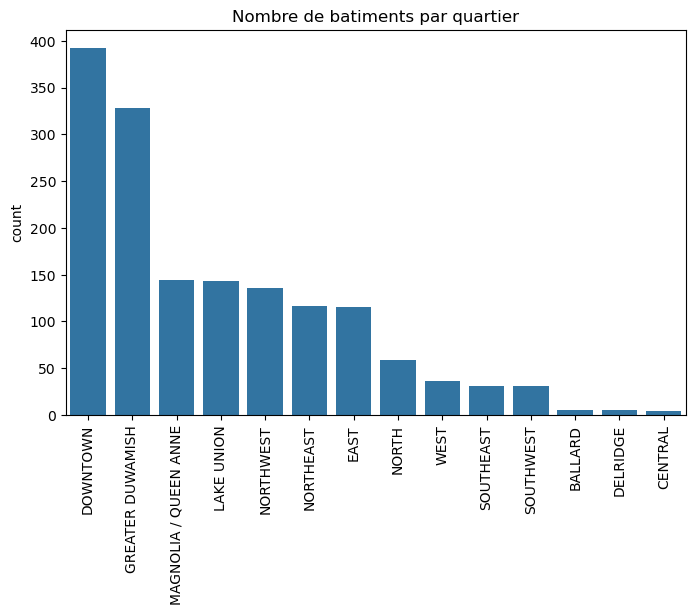

In [43]:
Neighborhood_col = 'Neighborhood'

# Show Neighborhood values
plt.figure(figsize=(8,5))
countplot = sns.countplot(x=Neighborhood_col, data=df, order=df[Neighborhood_col].sort_values().value_counts().index)
plt.xticks(rotation = 90)
plt.title("Nombre de batiments par quartier")
plt.xlabel("")
plt.show()

/var/folders/r1/0b6zw6ps21b2h1mw658vfs5r0000gn/T/ipykernel_94798/4003060730.py:6: UserWarning:


The palette list has fewer values (13) than needed (14) and will cycle, which may produce an uninterpretable plot.



Text(0.5, 1.0, 'Carte de Seatle montrant les quartiers')

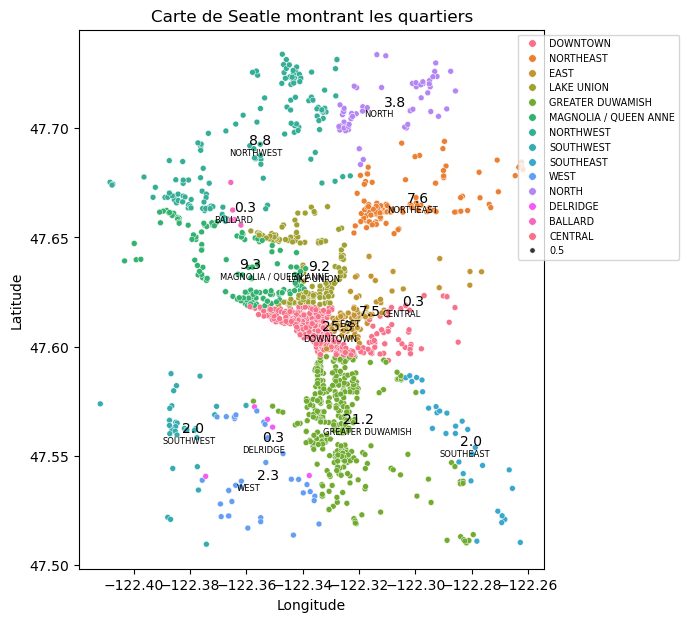

In [44]:
# serie des proportions de chaque arrondissement
df_prop_neigh=round(df['Neighborhood'].value_counts(normalize=True)*100,1)

# plot les neigh
plt.figure(figsize=(6,7))
sns.scatterplot(data=df,x='Longitude',y='Latitude',hue='Neighborhood', palette=sns.color_palette("husl", 13),size=0.5)
plt.legend(fontsize='x-small',markerscale=.9,loc='upper right', bbox_to_anchor=(1.3, 1))

# affiche les proportions assoc
for n in df_prop_neigh.index:
  x,y=df.loc[df['Neighborhood']==n,'Longitude'].mean(),df.loc[df['Neighborhood']==n,'Latitude'].mean()
  s=round(df_prop_neigh[n],2)
  plt.text(x=x,y=y,s=s)
  plt.text(x=x-.007,y=y-.005,s=n,fontsize=6)

plt.title('Carte de Seatle montrant les quartiers')

Je vais garder la longitude et la lattitude pour les modeles, je supprime donc les quartiers (Neighborhood)

In [45]:
df = df.drop(['Neighborhood'], axis=1)

### Gestion de l'année de construction des batiments en variable catégorielle avec pd.cut

In [46]:
df['YearBuilt'].value_counts().sort_index()

YearBuilt
1900    43
1901     2
1902     8
1903     1
1904    12
1905     3
1906    12
1907    12
1908    11
1909    14
1910    28
1911     6
1912    16
1913     8
1914    11
1915     5
1916    16
1917     8
1918     6
1919     4
1920    16
1921     9
1922    15
1923     9
1924    10
1925    16
1926    27
1927    15
1928    23
1929    18
1930    20
1931     9
1932     3
1935     1
1936     1
1937     7
1938     9
1939     2
1940     5
1941     7
1942     3
1944     2
1945     6
1946     9
1947     8
1948    11
1949     9
1950    15
1951    14
1952    15
1953    18
1954    18
1955    15
1956    17
1957    13
1958    10
1959    13
1960    28
1961    24
1962    27
1963    16
1964    16
1965    19
1966    23
1967    16
1968    18
1969    25
1970    31
1971    11
1972    10
1973    14
1974    16
1975    12
1976     9
1977    10
1978    14
1979    28
1980    25
1981    16
1982    16
1983    14
1984    10
1985    19
1986    16
1987    10
1988    22
1989    17
1990    16
1991    11
1992    11


In [47]:
# Définition des intervalles et des étiquettes de catégorie
bins = [1899, 1920, 1940, 1960, 1980, 2000, 2020]  # Intervalles
labels = ['1900-1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2015']  # Étiquettes de catégorie

# Création d'une nouvelle variable catégorielle en regroupant les années
df['YearBuiltCateg'] = pd.cut(df['YearBuilt'], bins=bins, labels=labels, right=False)

# Affichage du DataFrame avec la nouvelle variable catégorielle
print(df)

      OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3370          50221      2016  Nonresidential COS               Other   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0     47.61220 -122.33799       1927            

In [48]:
df['YearBuiltCateg'].value_counts().sort_index()

YearBuiltCateg
1900-1919    226
1920-1939    210
1940-1959    208
1960-1979    367
1980-1999    302
2000-2015    234
Name: count, dtype: int64

Gestion des valeurs années de construction par 20 années, je peux supprimer la valeur de l'année initale

<Axes: xlabel='YearBuiltCateg', ylabel='Count'>

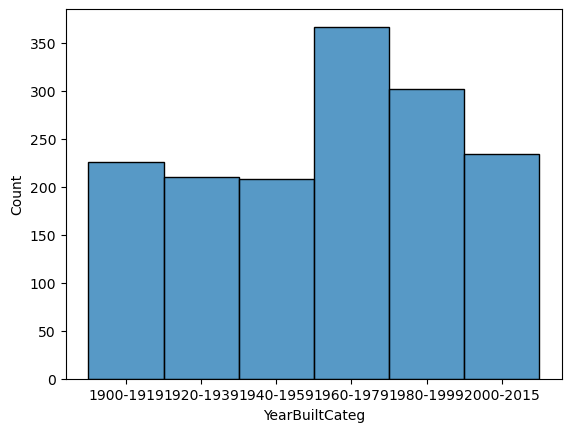

In [49]:
plt.figure()
sns.histplot(df['YearBuiltCateg'])

In [50]:
df.drop('YearBuiltCateg', axis=1, inplace=True)

In [51]:
df = df.rename(columns={ 'YearBuilt':'Agebuilding'})
df['Agebuilding'] = df['DataYear'] - df['Agebuilding']

In [52]:
df.drop('DataYear', axis=1, inplace=True)

### NombreBatiment valeurs abérrantes 

In [53]:
df['NumberofBuildings'].value_counts().sort_index()

NumberofBuildings
0.0        52
1.0      1443
2.0        14
3.0        12
4.0         4
5.0         7
6.0         4
7.0         1
8.0         2
9.0         1
10.0        1
11.0        1
14.0        2
23.0        1
27.0        1
111.0       1
Name: count, dtype: int64

In [54]:
df.loc[df['NumberofBuildings'] == 0.0,'NumberofBuildings'] = 1 

Remplacement de valeurs abérantes, mettre 1 à la place de zéro pour le nombre de batiments

### Visualisation des colonnes

In [55]:
df['PropertyGFATotal'].value_counts().sort_index()

PropertyGFATotal
11285      1
11685      1
11968      1
12769      1
13157      1
          ..
1605578    1
1765970    1
1952220    1
2200000    1
9320156    1
Name: count, Length: 1473, dtype: int64

In [56]:
df['PropertyGFAParking'].value_counts().sort_index()

PropertyGFAParking
0         1217
1263         1
1392         1
2211         1
2352         1
3764         1
3834         1
4222         1
4256         1
4914         1
4968         1
5400         1
5680         1
6010         1
6034         1
6062         1
6080         1
6200         1
6300         1
6350         1
6458         1
6922         1
6960         1
6985         1
7004         1
7056         1
7120         1
7132         1
7233         1
7308         1
7358         1
7450         1
7572         1
7757         1
7820         1
7956         1
8110         1
8161         1
8296         1
8399         1
8584         1
9226         1
9341         1
9605         1
9616         1
9999         1
10043        1
10285        1
10800        2
10849        1
11082        1
11250        1
11328        1
11400        1
11527        1
12000        1
12180        1
12379        1
12400        1
12586        1
12611        1
12870        1
12960        1
12990        1
12998        1
13124 

In [57]:
df['DefaultData'].value_counts()

DefaultData
False    1547
Name: count, dtype: int64

In [58]:
df['TotalGHGEmissions'].value_counts()

TotalGHGEmissions
6.30      3
7.49      2
4.80      2
5.97      2
41.80     2
         ..
150.88    1
324.25    1
109.16    1
109.85    1
41.27     1
Name: count, Length: 1488, dtype: int64

### Energy

Vapeur

In [59]:
df['SteamUse(kBtu)'].value_counts()

SteamUse(kBtu)
0.000000e+00    1434
1.530681e+06       1
2.309893e+05       1
1.739621e+06       1
1.165336e+06       1
1.158118e+06       1
3.578548e+06       1
8.826307e+05       1
4.505223e+05       1
1.517425e+05       1
1.349435e+08       1
4.047481e+06       1
1.736651e+06       1
7.413886e+06       1
2.003882e+06       1
1.639341e+06       1
2.887565e+06       1
2.662620e+05       1
2.068667e+06       1
3.593940e+06       1
9.941543e+05       1
9.864032e+05       1
7.815663e+06       1
3.472079e+05       1
3.995383e+05       1
7.710852e+05       1
1.754842e+07       1
5.650344e+06       1
6.090188e+06       1
7.620328e+05       1
5.473370e+06       1
5.482947e+05       1
7.388547e+07       1
1.355622e+07       1
1.854786e+07       1
3.103019e+07       1
2.513519e+06       1
1.664884e+05       1
3.820800e+05       1
8.156761e+05       1
5.007528e+05       1
3.406156e+05       1
9.411397e+05       1
7.489847e+05       1
6.820476e+05       1
7.625423e+05       1
1.329625e+07       

Electricité

In [60]:
df['Electricity(kBtu)'].value_counts()

Electricity(kBtu)
8.155080e+05    2
0.000000e+00    2
3.946027e+06    1
1.078230e+05    1
1.435563e+06    1
               ..
1.968655e+06    1
4.371815e+06    1
1.707414e+07    1
1.903641e+07    1
4.325542e+05    1
Name: count, Length: 1545, dtype: int64

Gaz

In [61]:
df['NaturalGas(kBtu)'].value_counts()

NaturalGas(kBtu)
0.000000e+00    443
2.268460e+05      2
1.276453e+06      1
9.073890e+05      1
2.988397e+06      1
               ... 
7.589685e+06      1
4.595080e+05      1
7.987580e+05      1
5.760220e+05      1
7.203420e+05      1
Name: count, Length: 1104, dtype: int64

In [62]:
err = abs( (df['NaturalGas(kBtu)'] + df['Electricity(kBtu)'] + df['SteamUse(kBtu)']) - df['SiteEnergyUse(kBtu)'])/abs(df['SiteEnergyUse(kBtu)'])
err.mean()

0.003517980931757973

Normalisation des source d'energie en 0/1 car pas besoin de la consommation étant donné qu'on la retrouve dans le total

In [65]:
df = df.drop(['NaturalGas(kBtu)','Electricity(kBtu)','SteamUse(kBtu)'], axis=1)

Supression des sources d'nergie car pas besoin

### Suppression supplémentaire

In [66]:
df.drop('DefaultData', axis=1, inplace=True)

In [67]:
df.drop(['BuildingType','GHGEmissionsIntensity'], axis=1, inplace=True)

BuildingType plus utile car j'ai sélectionné les batiments non résidentiel
GHGEmissionsIntensity: supprimée car elle est calculée à partir de 'TotalGHGEmissions'.

In [68]:
df.drop(['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)'], axis=1, inplace=True)

SiteEUI(kBtu/sf): supprimée car elle est calculée à partir de la variable 'SiteEnergyUse(kBtu)'

SourceEUI(kBtu/sf): supprimée car elle nécessite de faire des relevés couteux

In [69]:
df.shape

(1547, 22)

In [70]:
df.columns

Index(['OSEBuildingID', 'PrimaryPropertyType', 'Latitude', 'Longitude',
       'Agebuilding', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'Outlier', 'TotalGHGEmissions'],
      dtype='object')

### EnergySTAR

In [71]:
df['YearsENERGYSTARCertified'].value_counts()

YearsENERGYSTARCertified
2016                                                            11
2017                                                             5
2013                                                             4
2009                                                             4
20162015                                                         4
20172015                                                         3
20172016                                                         3
2010                                                             2
201720162015                                                     2
20112009                                                         2
2014                                                             2
20092005                                                         2
201620092008                                                     2
201620142012                                                     1
20162015201320122011201020092008     

In [72]:
df.drop('YearsENERGYSTARCertified', axis=1, inplace=True)

Pas de nécéssité

In [73]:
df['ENERGYSTARScore'].value_counts()

ENERGYSTARScore
100.0    28
98.0     27
95.0     25
89.0     24
96.0     22
91.0     21
69.0     21
97.0     20
1.0      19
94.0     19
72.0     18
88.0     18
93.0     17
80.0     17
82.0     17
57.0     17
92.0     17
77.0     16
75.0     16
83.0     16
78.0     15
79.0     15
87.0     14
90.0     14
73.0     14
84.0     13
55.0     13
99.0     13
62.0     13
81.0     13
71.0     12
56.0     12
53.0     11
60.0     11
86.0     11
67.0     11
66.0     11
58.0     11
65.0     11
43.0     11
85.0     11
63.0     10
37.0     10
8.0      10
49.0     10
76.0     10
61.0      9
70.0      9
34.0      8
32.0      8
2.0       8
3.0       8
5.0       7
47.0      7
25.0      7
16.0      7
12.0      7
51.0      7
38.0      7
64.0      7
54.0      7
68.0      7
29.0      6
18.0      6
59.0      6
6.0       6
74.0      6
50.0      6
20.0      6
31.0      6
22.0      5
44.0      5
33.0      5
15.0      5
52.0      5
41.0      5
26.0      5
10.0      5
19.0      5
45.0      5
23.0      5
42.0      5


<Axes: xlabel='ENERGYSTARScore', ylabel='Count'>

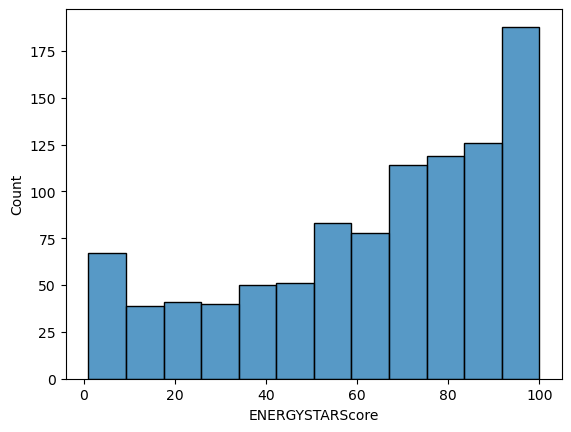

In [74]:
plt.figure()
sns.histplot(df['ENERGYSTARScore'])

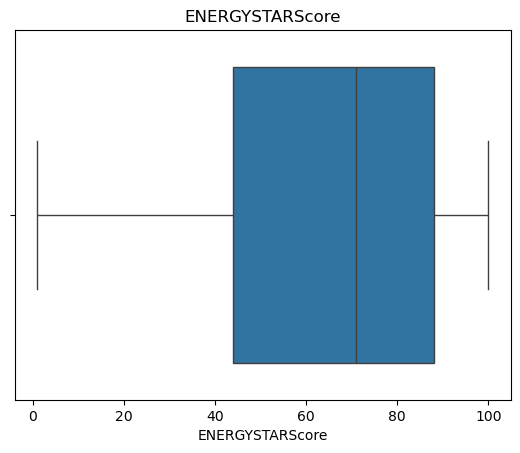

In [75]:
plt.figure()
sns.boxplot(data = df['ENERGYSTARScore'], orient="h")
plt.title('ENERGYSTARScore')
plt.show()

### Type de batiments

In [76]:
df['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  484
Non-Refrigerated Warehouse                              197
Other                                                    95
Retail Store                                             93
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
K-12 School                                              50
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Commu

In [77]:
df['SecondLargestPropertyUseType'].value_counts()

SecondLargestPropertyUseType
Parking                                                 331
Office                                                  167
Retail Store                                             84
Other                                                    43
Restaurant                                               29
Non-Refrigerated Warehouse                               28
Fitness Center/Health Club/Gym                           16
Multifamily Housing                                      12
Data Center                                              12
Other - Services                                         11
Supermarket/Grocery Store                                 9
Laboratory                                                8
Medical Office                                            8
Bank Branch                                               7
Other - Entertainment/Public Assembly                     7
Distribution Center                                       7
K-12 School

In [78]:
df['ThirdLargestPropertyUseType'].value_counts()

ThirdLargestPropertyUseType
Office                                                  49
Retail Store                                            47
Parking                                                 44
Other                                                   39
Restaurant                                              32
Non-Refrigerated Warehouse                              14
Data Center                                             13
Multifamily Housing                                     12
Swimming Pool                                           10
Medical Office                                           9
Social/Meeting Hall                                      8
Food Service                                             8
Pre-school/Daycare                                       8
Bank Branch                                              5
Other - Restaurant/Bar                                   5
Financial Office                                         4
Fitness Center/Health Club/G

In [79]:
Type_batiments = df[['OSEBuildingID','PrimaryPropertyType','PropertyGFATotal','LargestPropertyUseType','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',]]

In [80]:
Type_batiments[Type_batiments['LargestPropertyUseType'] == 'Other']

,OSEBuildingID,PrimaryPropertyType,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
21,27,Other,385274,Other,385274.0,NaN,NaN,NaN,NaN
69,103,Other,389000,Other,368000.0,NaN,NaN,NaN,NaN
70,104,Other,91213,Other,65000.0,NaN,NaN,NaN,NaN
71,106,Other,396085,Other,278500.0,NaN,NaN,NaN,NaN
73,110,Other,52000,Other,52000.0,NaN,NaN,NaN,NaN
74,111,Other,60696,Other,108000.0,NaN,NaN,NaN,NaN
75,112,Other,262048,Other,296000.0,NaN,NaN,NaN,NaN
89,131,Other,56521,Other,49000.0,NaN,NaN,NaN,NaN
90,132,Other,206934,Other,119146.0,Parking,0.000000,NaN,NaN
100,163,Other,61156,Other,42755.0,Office,29219.000000,NaN,NaN


In [81]:
df.loc[df['OSEBuildingID'] == 163, 'LargestPropertyUseType'] = 'Office'

In [82]:
df.loc[df['OSEBuildingID'] == 187, 'LargestPropertyUseType'] = 'Courthouse'

In [83]:
df.loc[df['OSEBuildingID'] == 785, 'LargestPropertyUseType'] = 'Office'

In [84]:
df.loc[df['OSEBuildingID'] == 830, 'LargestPropertyUseType'] = 'Office'

In [85]:
df.loc[df['OSEBuildingID'] == 20474	, 'LargestPropertyUseType'] = 'Retail Store'

In [86]:
df.loc[df['OSEBuildingID'] == 22259	, 'LargestPropertyUseType'] = 'Retail Store'

In [87]:
df.loc[df['OSEBuildingID'] == 24227	, 'LargestPropertyUseType'] = 'Retail Store'

In [88]:
df.loc[df['OSEBuildingID'] == 24579, 'LargestPropertyUseType'] = 'Office'

In [89]:
df.loc[df['OSEBuildingID'] == 24700, 'LargestPropertyUseType'] = 'Other - Entertainment/Public Assembly'

In [90]:
df.loc[df['OSEBuildingID'] == 24959, 'LargestPropertyUseType'] = 'Non-Refrigerated Warehouse'

In [91]:
df.loc[df['OSEBuildingID'] == 49725	, 'LargestPropertyUseType'] = 'Hospital (General Medical & Surgical)'

In [92]:
df[df['OSEBuildingID'] == 187]

,OSEBuildingID,PrimaryPropertyType,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),Outlier,TotalGHGEmissions
117,187,Other,47.60462,-122.31549,45,3.0,6,250981,0,250981,Courthouse,137565.0,Courthouse,78357.0,NaN,NaN,NaN,65.699997,13071700.0,NaN,422.39


J'ai remplacer des valeurs autres

In [93]:
class_propriete = {
    #Bureau
    'Large Office' : 'Bureau',
    'Office' : 'Bureau',
    'Small- and Mid-Sized Office' : 'Bureau',
    'Other - Services' : 'Bureau',
    'Data Center' : 'Bureau', 
    'Other - Technology/Science' : 'Bureau', 
    'Bank Branch' : 'Bureau', 
    'Financial Office' : 'Bureau', 
    #Industrie
    'Manufacturing/Industrial Plant' : 'Industrie',
    'Other - Utility' : 'Industrie',
    'Distribution Center' : 'Industrie',
    'Distribution Center\n' : 'Industrie',
    'Non-Refrigerated Warehouse' : 'Industrie',
    'Refrigerated Warehouse' : 'Industrie',
    'Self-Storage Facility' : 'Industrie',
    'Self-Storage Facility\n' : 'Industrie',
    'Warehouse' : 'Industrial', 
    #Commerce
    'Automobile Dealership' : 'Commerce',
    'Convenience Store without Gas Station' : 'Commerce',
    'Enclosed Mall' : 'Commerce',
    'Lifestyle Center' : 'Commerce',
    'Other - Mall' : 'Commerce',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Commerce',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Commerce',
    'Retail Store' : 'Commerce',
    'Strip Mall' : 'Commerce',
    'Supermarket / Grocery Store' : 'Commerce',
    'Supermarket/Grocery Store' : 'Commerce',
    'Wholesale Club/Supercenter' : 'Commerce',
    #Education
    'Adult Education' : 'Education',
    'College/University' : 'Education',
    'K-12 School' : 'Education',
    'Other - Education' : 'Education',
    'Pre-school/Daycare' : 'Education',
    'SPS-District K-12' : 'Education',
    'University' : 'Education',
    'Vocational School' : 'Education',
    #Loisirs
    'Bar/Nightclub' : 'Loisirs',
    'Convention Center' : 'Loisirs',
    'Fitness Center/Health Club/Gym' : 'Loisirs',
    'Movie Theater' : 'Loisirs',
    'Museum' : 'Loisirs',
    'Other - Entertainment/Public Assembly' : 'Loisirs',
    'Other - Recreation' : 'Loisirs',
    'Performing Arts' : 'Loisirs',
    'Social/Meeting Hall' : 'Loisirs',
    'Swimming Pool' : 'Loisirs',
    #Restaurant
    'Fast Food Restaurant' : 'Restaurant',
    'Food Sales' : 'Restaurant',
    'Food Service' : 'Restaurant',
    'Other - Restaurant/Bar' : 'Restaurant',
    'Restaurant' : 'Restaurant',
    'Restaurant\n' : 'Restaurant',
    #Medical
    'Hospital' : 'Medical',
    'Hospital (General Medical & Surgical)' : 'Medical',
    'Laboratory' : 'Medical',
    'Medical Office' : 'Medical',
    'Other/Specialty Hospital' : 'Medical',
    'Outpatient Rehabilitation/Physical Therapy' : 'Medical',
    'Residential Care Facility' : 'Medical',
    'Urgent Care/Clinic/Other Outpatient' : 'Medical',
    #Servicepublic
    'Courthouse' : 'Servicepublic',
    'Fire Station' : 'Servicepublic',
    'Library' : 'Servicepublic',
    'Police Station' : 'Servicepublic',
    'Other - Public Services' : 'Servicepublic',
    'Worship Facility' : 'Servicepublic',
    #Autres
    'Mixed Use Property' : 'Autres',
    'Other' : 'Autres',
    'Parking' : 'Autres',
    #Hebergement
    'Hotel' : 'Hebergement',
    'High-Rise Multifamily' : 'Hebergement',
    'Low-Rise Multifamily' : 'Hebergement',
    'Mid-Rise Multifamily' : 'Hebergement',
    'Multifamily Housing' : 'Hebergement',
    'Other - Lodging/Residential' : 'Hebergement',
    'Prison/Incarceration' : 'Hebergement',
    'Residence Hall' : 'Hebergement',
    'Residence Hall/Dormitory' : 'Hebergement',
    'Senior Care Community' : 'Hebergement',
}

In [94]:
colonne_a_traiter = ['PrimaryPropertyType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','LargestPropertyUseType']

In [95]:
for col in colonne_a_traiter: 
    df[col] = df[col].replace(class_propriete, regex=False)

In [96]:
df[['OSEBuildingID','PrimaryPropertyType','PropertyGFATotal','LargestPropertyUseType','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',]]

,OSEBuildingID,PrimaryPropertyType,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
0,1,Hebergement,88434,Hebergement,88434.0,NaN,NaN,NaN,NaN
1,2,Hebergement,103566,Hebergement,83880.0,Autres,15064.0,Restaurant,4622.0
2,3,Hebergement,956110,Hebergement,756493.0,NaN,NaN,NaN,NaN
3,5,Hebergement,61320,Hebergement,61320.0,NaN,NaN,NaN,NaN
4,8,Hebergement,175580,Hebergement,123445.0,Autres,68009.0,Loisirs,0.0
...,...,...,...,...,...,...,...,...,...
3370,50221,Autres,18261,Loisirs,18261.0,NaN,NaN,NaN,NaN
3372,50223,Autres,16000,Loisirs,16000.0,NaN,NaN,NaN,NaN
3373,50224,Autres,13157,Loisirs,7583.0,Loisirs,5574.0,Loisirs,0.0
3374,50225,Autres,14101,Loisirs,6601.0,Loisirs,6501.0,Education,484.0


In [97]:
df['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Bureau           454
Autres           358
Industrial       185
Commerce         125
Hebergement      118
Industrie         93
Education         74
Servicepublic     69
Medical           59
Restaurant        12
Name: count, dtype: int64

In [98]:
df['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Bureau           504
Industrie        301
Commerce         162
Hebergement      136
Autres           114
Education         81
Servicepublic     79
Loisirs           77
Medical           74
Restaurant        15
Name: count, dtype: int64

LargestPropertyUseType est plus précis, je garde cette variable

Etant donné que dans nos batiments, nous avons encore des batiments destinés à l'hébergement, nous les retirons

In [99]:
conditions_hebergement = (
    (df['PrimaryPropertyType'] == 'Hebergement') |
    (df['SecondLargestPropertyUseType'] == 'Hebergement') |
    (df['ThirdLargestPropertyUseType'] == 'Hebergement') |
    (df['LargestPropertyUseType'] == 'Hebergement')
)

# Créer un nouveau DataFrame sans les lignes où les conditions sont remplies
df = df[~conditions_hebergement]

# Afficher le DataFrame filtré
print("\nDataFrame après suppression des lignes contenant 'Hebergement' :")
print(df)


DataFrame après suppression des lignes contenant 'Hebergement' :
      OSEBuildingID PrimaryPropertyType  Latitude  Longitude  Agebuilding  \
5                 9              Autres  47.61623 -122.33657           17   
7                11              Autres  47.61327 -122.33136           90   
15               21              Autres  47.60649 -122.33297           12   
16               22              Autres  47.60546 -122.33279           86   
18               24              Autres  47.60515 -122.33159          109   
...             ...                 ...       ...        ...          ...   
3370          50221              Autres  47.54067 -122.37441           34   
3372          50223              Autres  47.59625 -122.32283           12   
3373          50224              Autres  47.63644 -122.35784           42   
3374          50225              Autres  47.52832 -122.32431           27   
3375          50226              Autres  47.53939 -122.29536           78   

      Num

<Axes: >

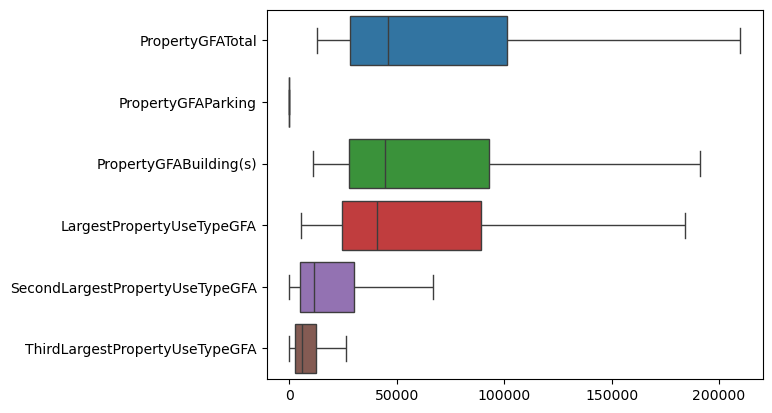

In [100]:
sns.boxplot(df[['PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']],orient='h',showfliers=False)

### Gestion des valeurs abérrantes

In [101]:
df.shape

(1384, 21)

In [102]:
df =  df[~((df['LargestPropertyUseTypeGFA'] > df['PropertyGFATotal']) 
                              | (df['PropertyGFABuilding(s)'] > df['PropertyGFATotal']) 
                              | (df['PropertyGFAParking'] > df['PropertyGFATotal']) 
                              | (df['SecondLargestPropertyUseTypeGFA'] > df['LargestPropertyUseTypeGFA'])
                              | (df['ThirdLargestPropertyUseTypeGFA'] > df['SecondLargestPropertyUseTypeGFA'])
                               )]
print(df.shape)

(1219, 21)


Supression des lignes ou la surface d'une proprieté est plus grande que la surface totale

### Gestion des valeurs manquantes

In [103]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Outlier                            1.000000
ThirdLargestPropertyUseTypeGFA     0.769483
ThirdLargestPropertyUseType        0.769483
SecondLargestPropertyUseTypeGFA    0.433142
SecondLargestPropertyUseType       0.433142
ENERGYSTARScore                    0.368335
LargestPropertyUseType             0.002461
LargestPropertyUseTypeGFA          0.002461
SiteEUIWN(kBtu/sf)                 0.000820
SiteEnergyUse(kBtu)                0.000000
OSEBuildingID                      0.000000
PrimaryPropertyType                0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
NumberofBuildings                  0.000000
Agebuilding                        0.000000
Longitude                          0.000000
Latitude                           0.000000
TotalGHGEmissions                  0.000000
dtype: float64

In [104]:
df['LargestPropertyUseTypeGFA'].isna().sum()/df.shape[0]

0.002461033634126333

In [105]:
df[df['LargestPropertyUseTypeGFA'].isna()]

,OSEBuildingID,PrimaryPropertyType,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),Outlier,TotalGHGEmissions
353,496,Industrie,47.66838,-122.39310,70,2.0,2,111445,0,111445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.000000,5.697472e+06,NaN,163.83
2414,25568,Bureau,47.64747,-122.34086,8,1.0,4,48350,0,48350,NaN,NaN,NaN,NaN,NaN,NaN,45.0,74.699997,3.168131e+06,NaN,22.09
2459,25711,Restaurant,47.59697,-122.32474,103,1.0,3,28800,0,28800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.500000,8.999242e+05,NaN,29.21


In [106]:
df.loc[df['OSEBuildingID'] == 496, 'LargestPropertyUseTypeGFA'] = '111445'
df.loc[df['OSEBuildingID'] == 25568, 'LargestPropertyUseTypeGFA'] = '48350'
df.loc[df['OSEBuildingID'] == 25711, 'LargestPropertyUseTypeGFA'] = '28800'

/var/folders/r1/0b6zw6ps21b2h1mw658vfs5r0000gn/T/ipykernel_94798/3122026112.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111445' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [107]:
df.loc[df['OSEBuildingID'] == 496, 'LargestPropertyUseType'] = 'Bureau'
df.loc[df['OSEBuildingID'] == 25568, 'LargestPropertyUseType'] = 'Industrie'
df.loc[df['OSEBuildingID'] == 25711, 'LargestPropertyUseType'] = 'Restaurant'

In [108]:
df.loc[df['OSEBuildingID'] == 757, 'SiteEUIWN(kBtu/sf)'] = df['SiteEnergyUse(kBtu)']/df['PropertyGFATotal']

In [109]:
df.loc[df['OSEBuildingID'] == 757]

,OSEBuildingID,PrimaryPropertyType,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),Outlier,TotalGHGEmissions
563,757,Bureau,47.61051,-122.34439,37,1.0,7,131143,87160,43983,Bureau,120248.0,Commerce,10853.0,NaN,NaN,93.0,39.478054,5177270.5,NaN,109.16


In [110]:
(df['SecondLargestPropertyUseTypeGFA'].isna().sum()/df.shape[0])

0.4331419196062346

In [111]:
(df['ThirdLargestPropertyUseTypeGFA'].isna().sum()/df.shape[0])

0.7694831829368335

Suppression de primary property type, car le type de batiments est trop vaste, nous gardons uniquement LargestPropertyUseType et nous supprimons aussi SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA

In [112]:
df.drop(['PrimaryPropertyType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','SecondLargestPropertyUseType','ThirdLargestPropertyUseType','SiteEnergyUse(kBtu)'], axis=1, inplace=True)

In [113]:
df.columns

Index(['OSEBuildingID', 'Latitude', 'Longitude', 'Agebuilding',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'Outlier', 'TotalGHGEmissions'],
      dtype='object')

In [114]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Outlier                   1.000000
ENERGYSTARScore           0.368335
OSEBuildingID             0.000000
Latitude                  0.000000
Longitude                 0.000000
Agebuilding               0.000000
NumberofBuildings         0.000000
NumberofFloors            0.000000
PropertyGFATotal          0.000000
PropertyGFAParking        0.000000
PropertyGFABuilding(s)    0.000000
LargestPropertyUseType    0.000000
SiteEUIWN(kBtu/sf)        0.000000
TotalGHGEmissions         0.000000
dtype: float64

### Outliers

In [115]:
df.shape

(1219, 14)

In [116]:
df['Outlier'].value_counts()

Series([], Name: count, dtype: int64)

In [117]:
# Ligne_Outlier = df[(df['Outlier'] == 'Low outlier') | (df['Outlier'] == 'High outlier')]
# print(Ligne_Outlier)
# df = df.drop(Ligne_Outlier.index)

In [118]:
df.drop('Outlier', axis=1, inplace=True)

Supression des lignes Outliers

In [119]:
df.describe()

,OSEBuildingID,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUIWN(kBtu/sf),TotalGHGEmissions
count,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,1.219000e+03,1219.000000,1.219000e+03,770.000000,1219.000000,1219.000000
mean,16081.478261,47.615340,-122.333957,55.193601,1.189500,4.140279,1.225324e+05,15003.025431,1.075293e+05,63.767532,77.027135,155.185217
std,13321.345125,0.046722,0.023574,32.592049,3.298159,6.975856,3.335428e+05,46614.435417,3.194266e+05,29.016998,79.778179,597.661065
min,9.000000,47.509590,-122.411820,1.000000,1.000000,0.000000,1.276900e+04,0.000000,1.092500e+04,1.000000,0.000000,0.000000
25%,612.500000,47.584975,-122.342790,29.000000,1.000000,1.000000,2.835000e+04,0.000000,2.740900e+04,45.000000,36.000000,18.860000
50%,21212.000000,47.611940,-122.333270,51.000000,1.000000,2.000000,4.605900e+04,0.000000,4.416200e+04,71.000000,54.500000,44.480000
75%,24490.500000,47.648320,-122.323165,86.500000,1.000000,4.000000,1.028035e+05,0.000000,9.360750e+04,89.000000,85.799999,120.790000
max,50226.000000,47.733870,-122.261800,116.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,12307.160000


In [120]:
plot_valeurs_manquantes(df, 'valeursmanquantesnettoyer')

<Figure size 640x480 with 0 Axes>

In [121]:
colonnes_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()
colonnes_categorielles = df.select_dtypes(include=[object]).columns.tolist()

print("Colonnes numériques:", colonnes_numeriques)
print("Colonnes catégorielles:", colonnes_categorielles)

Colonnes numériques: ['OSEBuildingID', 'Latitude', 'Longitude', 'Agebuilding', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions']
Colonnes catégorielles: ['LargestPropertyUseType']


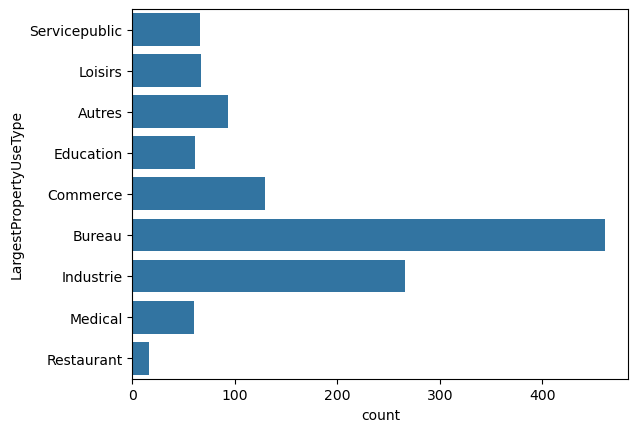

In [122]:
for col in colonnes_categorielles:
    sns.countplot(y=col, data=df)
    plt.show()

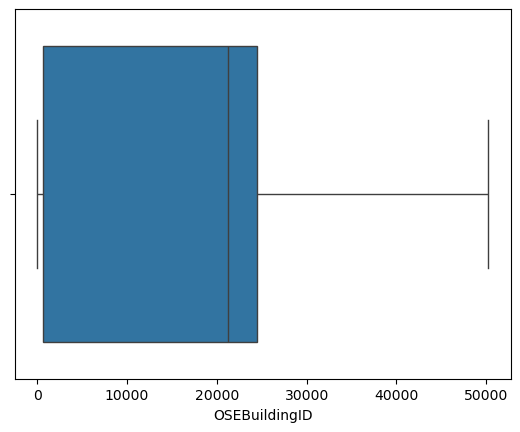

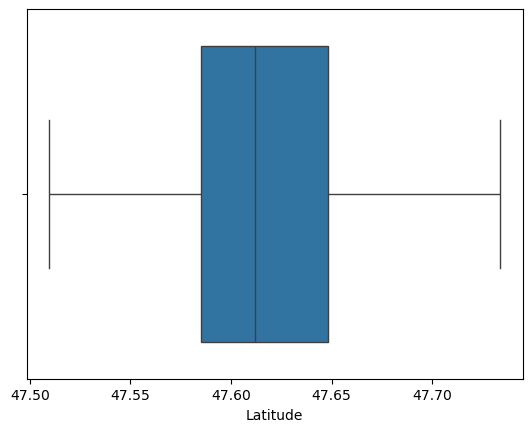

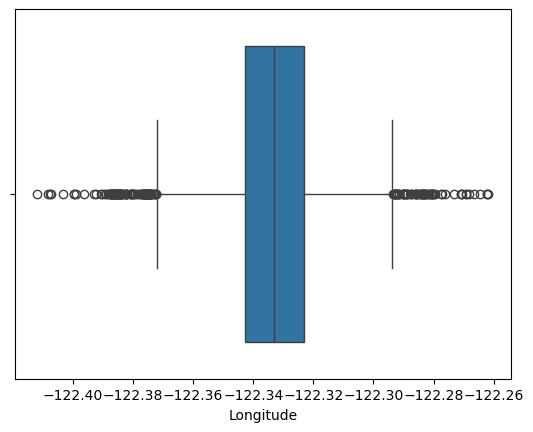

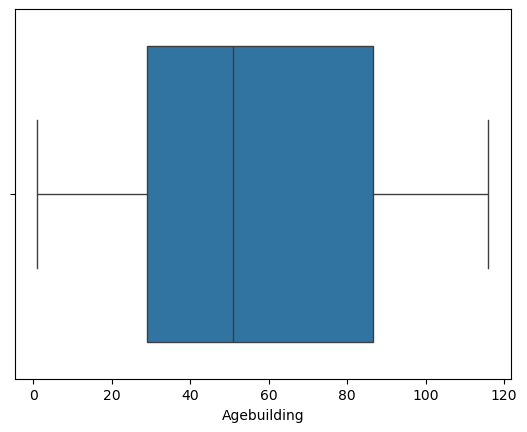

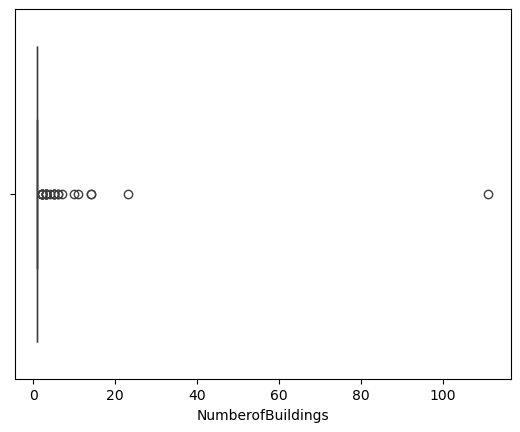

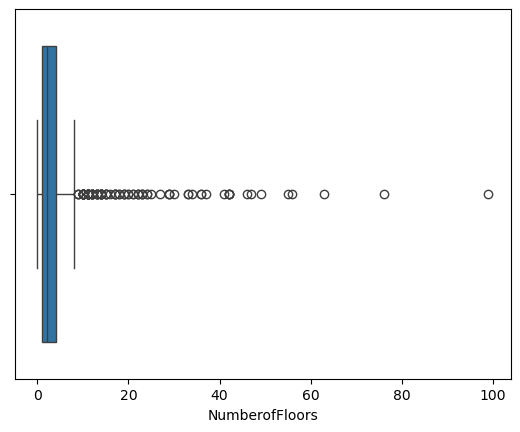

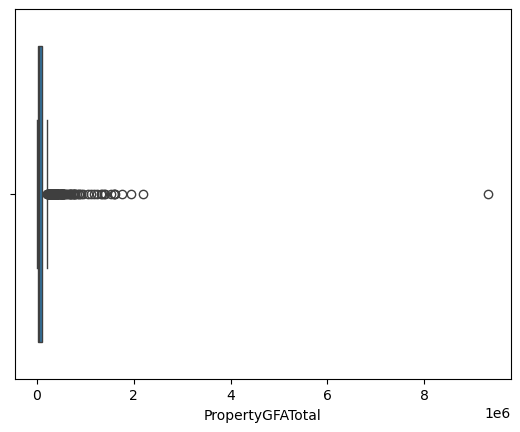

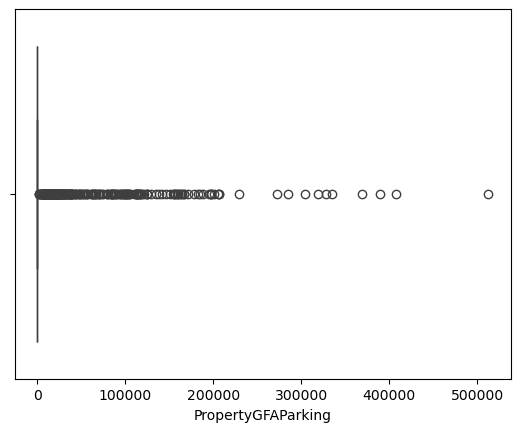

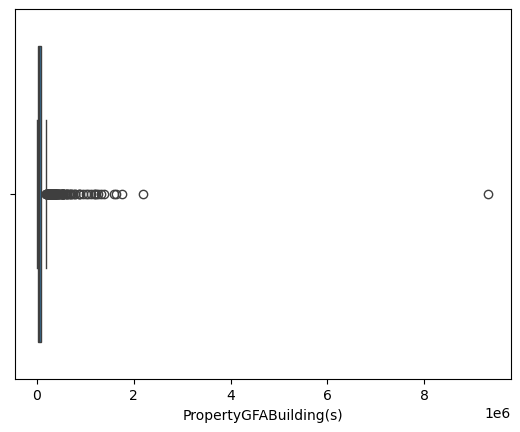

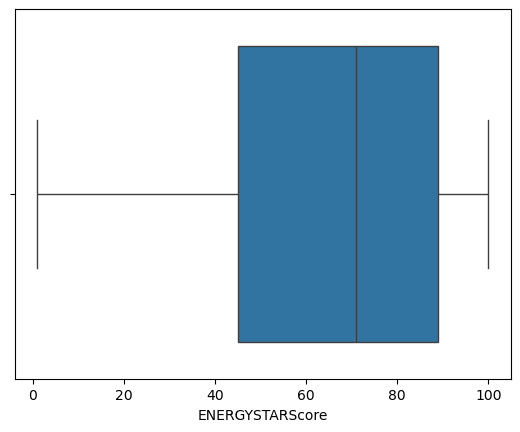

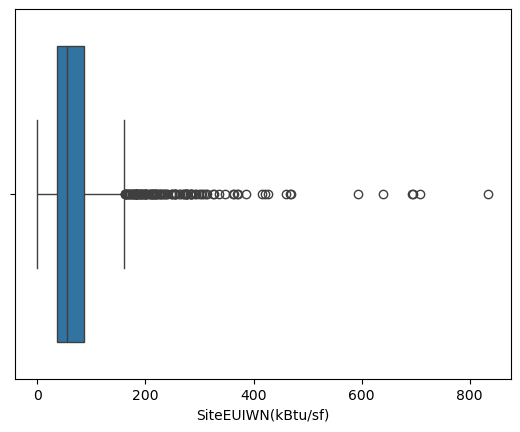

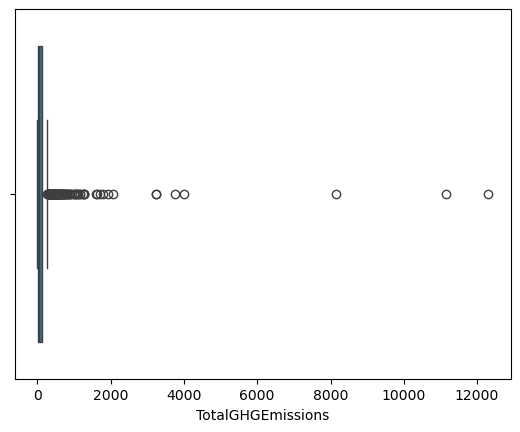

In [123]:
for col in colonnes_numeriques:
    sns.boxplot(x=df[col])
    plt.show()

### IQR Floors

Détermination de l'IQR pour les outliers 
L'IQR est défini comme la différence entre le troisième quatile (Q3) et le premier quartile (Q1) de la distribution des données. Les bornes inférieure et supérieure de la place plausible sont définies comme : 
- Limite inférieure : Q1 -1,5 xIQR
- Limite supérieure : Q3 +1,5xIQR

In [124]:
outliers_floors = detect_outliers_iqr(df,'NumberofFloors')
outliers_floors.shape

(95, 13)

95 outliers à supprimer

In [125]:
outliers_floors = outliers_floors.index
df.drop(outliers_floors, inplace=True)

In [126]:
df.shape

(1124, 13)

### IQR Nb Batiments

In [127]:
outliers_building = detect_outliers_iqr(df,'NumberofBuildings')
outliers_building.shape

(24, 13)

In [128]:
outliers_building = outliers_building.index
df.drop(outliers_building, inplace=True)

In [129]:
df.shape

(1100, 13)

In [130]:
df.describe()

,OSEBuildingID,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUIWN(kBtu/sf),TotalGHGEmissions
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1.100000e+03,1100.000000,1.100000e+03,685.000000,1100.000000,1100.000000
mean,16990.440000,47.615739,-122.334157,56.574545,1.0,2.652727,8.077412e+04,9886.587273,7.088754e+04,61.858394,76.952435,107.154436
std,12878.794279,0.048214,0.024342,32.679892,0.0,1.726352,1.317135e+05,32491.288421,1.195720e+05,29.427164,80.716885,253.507207
min,9.000000,47.509590,-122.411820,1.000000,1.0,0.000000,1.276900e+04,0.000000,1.092500e+04,1.000000,0.000000,0.000000
25%,692.750000,47.582192,-122.344352,30.000000,1.0,1.000000,2.736650e+04,0.000000,2.627375e+04,42.000000,34.299999,17.235000
50%,21400.000000,47.613160,-122.333160,53.500000,1.0,2.000000,4.206400e+04,0.000000,4.022700e+04,69.000000,53.650000,38.960000
75%,24589.500000,47.649760,-122.322635,88.000000,1.0,4.000000,8.226175e+04,0.000000,7.109775e+04,87.000000,85.124998,93.297500
max,50226.000000,47.733870,-122.261800,116.000000,1.0,8.000000,2.200000e+06,335109.000000,2.200000e+06,100.000000,834.400024,3995.450000


### IQR TotalGHGEmissions

In [131]:
outliers_TotalGHGEmissions = detect_outliers_iqr(df,'TotalGHGEmissions')
outliers_TotalGHGEmissions.shape

(131, 13)

In [132]:
outliers_TotalGHGEmissions = outliers_TotalGHGEmissions.index
df.drop(outliers_TotalGHGEmissions, inplace=True)

### IQR SiteEUIWN(kBtu/sf)

In [133]:
outliers_SiteEUIWN = detect_outliers_iqr(df,'SiteEUIWN(kBtu/sf)')
outliers_SiteEUIWN.shape

(58, 13)

In [134]:
outliers_SiteEUIWN = outliers_SiteEUIWN.index
df.drop(outliers_SiteEUIWN, inplace=True)

### IQR GFA Total

In [135]:
outliers_PropertyGFATotal= detect_outliers_iqr(df,'PropertyGFATotal')
outliers_PropertyGFATotal.shape

(80, 13)

In [136]:
outliers_PropertyGFATotal = outliers_PropertyGFATotal.index
df.drop(outliers_PropertyGFATotal, inplace=True)

### OSEBuildingID en index

In [137]:
df.set_index('OSEBuildingID', inplace=True)

### Target

In [138]:
df[['SiteEUIWN(kBtu/sf)','TotalGHGEmissions','ENERGYSTARScore']].describe()

,SiteEUIWN(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
count,831.000000,831.000000,525.000000
mean,50.959059,39.152419,62.977143
std,28.680262,36.705625,28.091512
min,0.000000,0.400000,1.000000
25%,30.250000,12.905000,45.000000
50%,46.900002,28.270000,69.000000
75%,68.400002,51.780000,87.000000
max,136.000000,185.330000,100.000000


### Analyse

In [139]:
df.shape

(831, 12)

In [140]:
df.head()

,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),TotalGHGEmissions
OSEBuildingID,,,,,,,,,,,,
31,47.61500,-122.33081,86,1.0,2,67224,0,67224,Commerce,NaN,19.500000,9.13
38,47.66410,-122.33118,110,1.0,3,87262,0,87262,Bureau,NaN,69.800003,157.77
41,47.66172,-122.29598,61,1.0,2,110356,0,110356,Industrie,NaN,12.400000,3.93
50,47.65671,-122.39047,26,1.0,2,54986,0,54986,Education,97.0,32.799999,31.47
52,47.66587,-122.38476,55,1.0,2,94900,0,94900,Bureau,57.0,68.900002,130.56


/var/folders/r1/0b6zw6ps21b2h1mw658vfs5r0000gn/T/ipykernel_94798/1309740707.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/r1/0b6zw6ps21b2h1mw658vfs5r0000gn/T/ipykernel_94798/1309740707.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/r1/0b6zw6ps21b2h1mw658vfs5r0000gn/T/ipykernel_94798/1

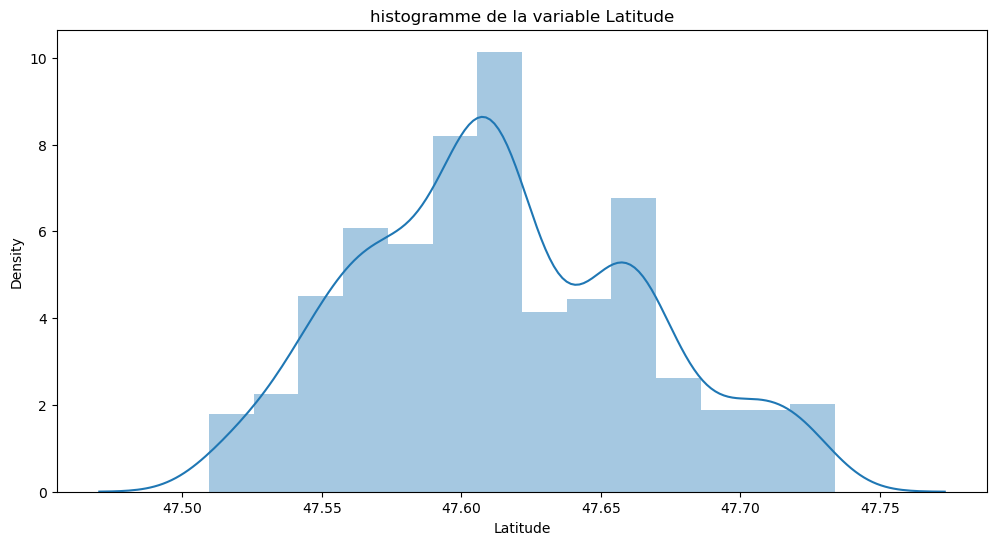

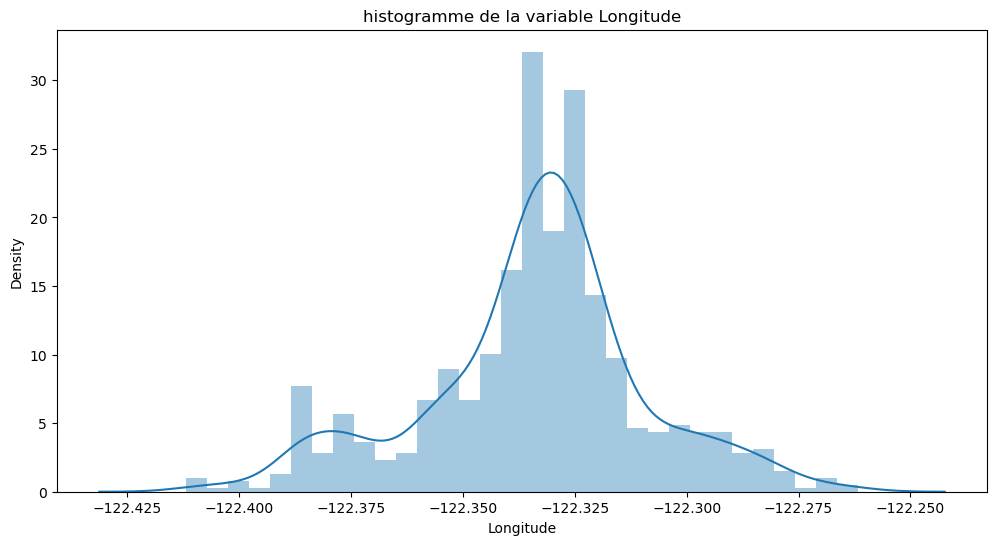

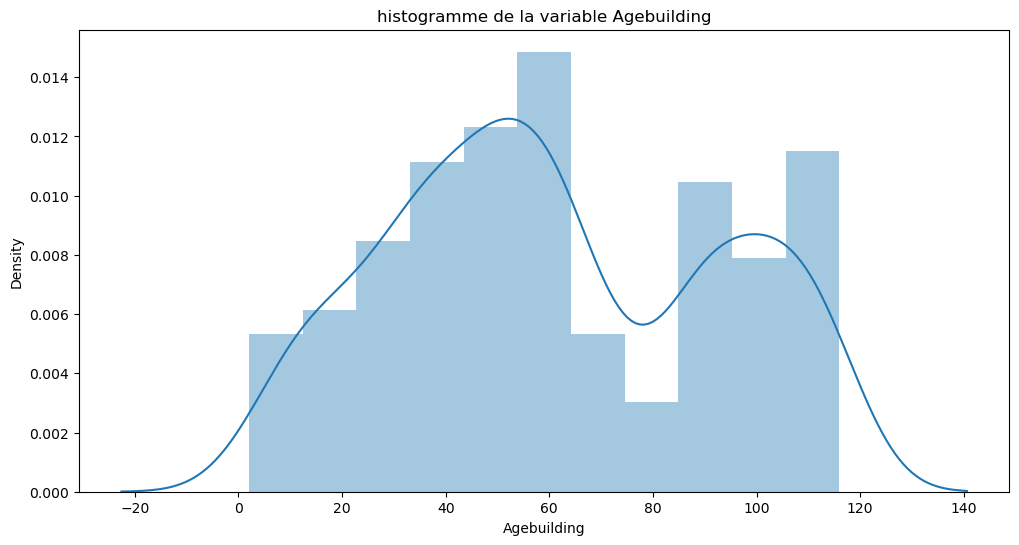

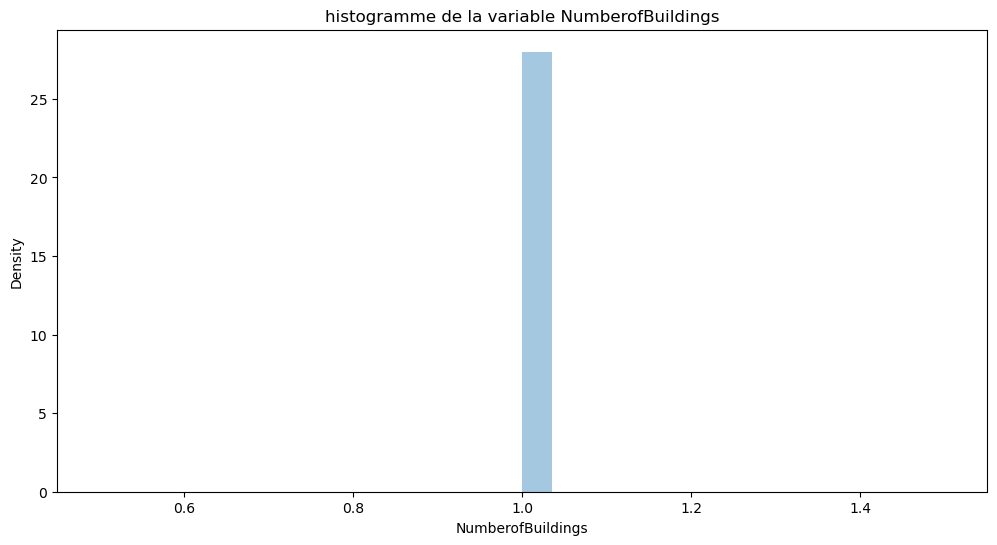

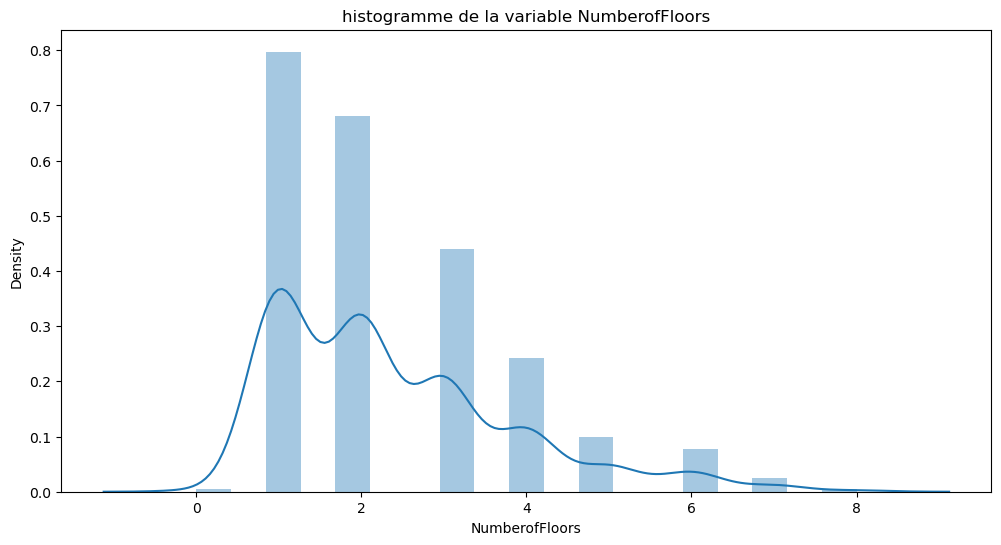

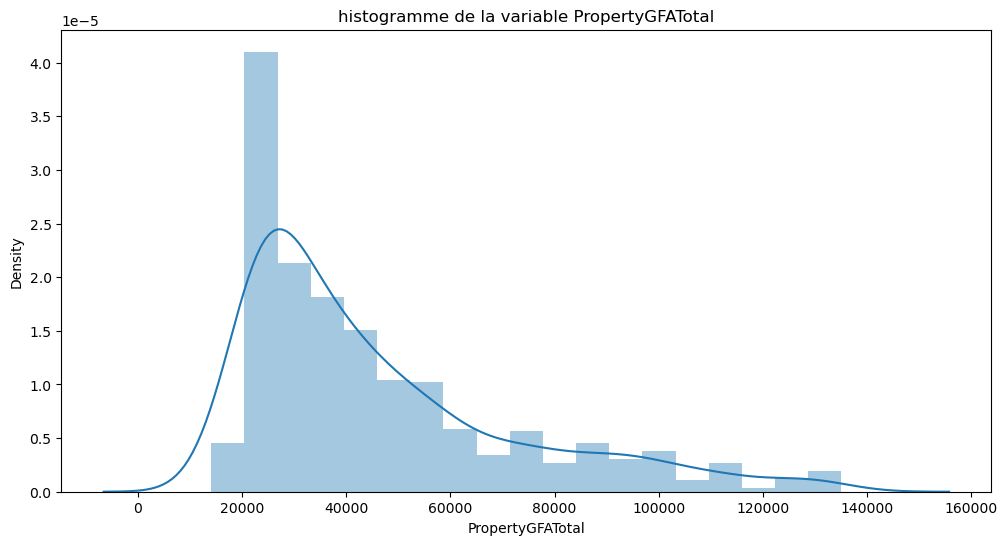

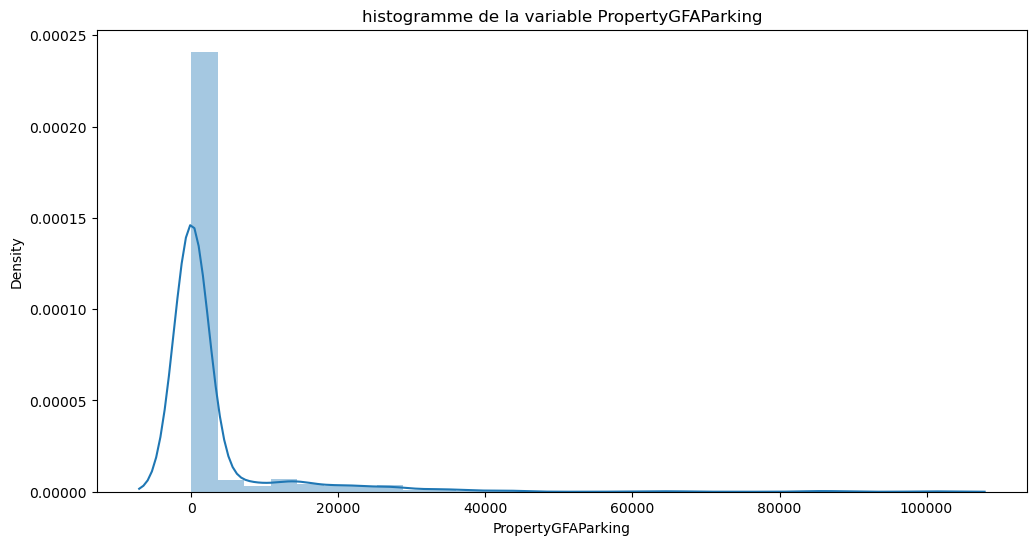

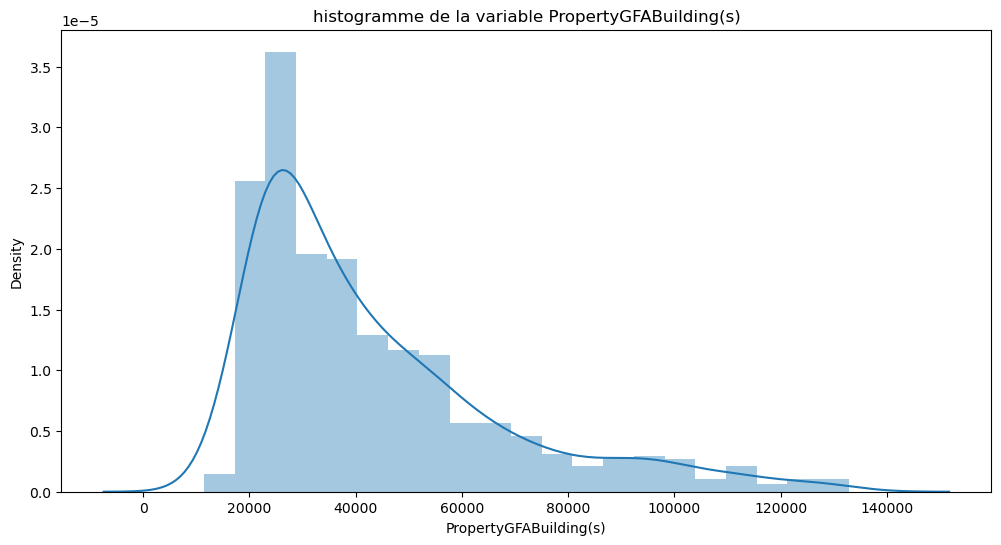

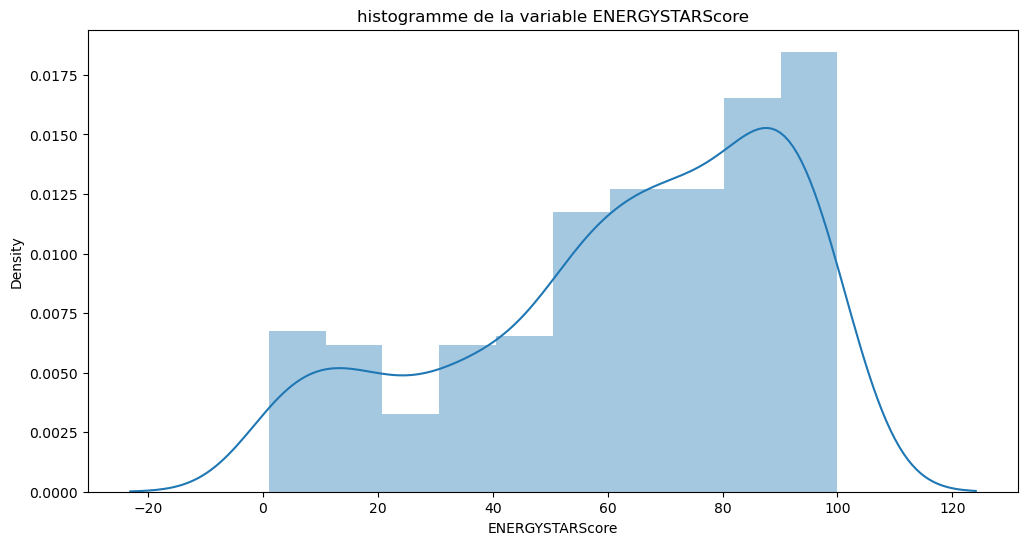

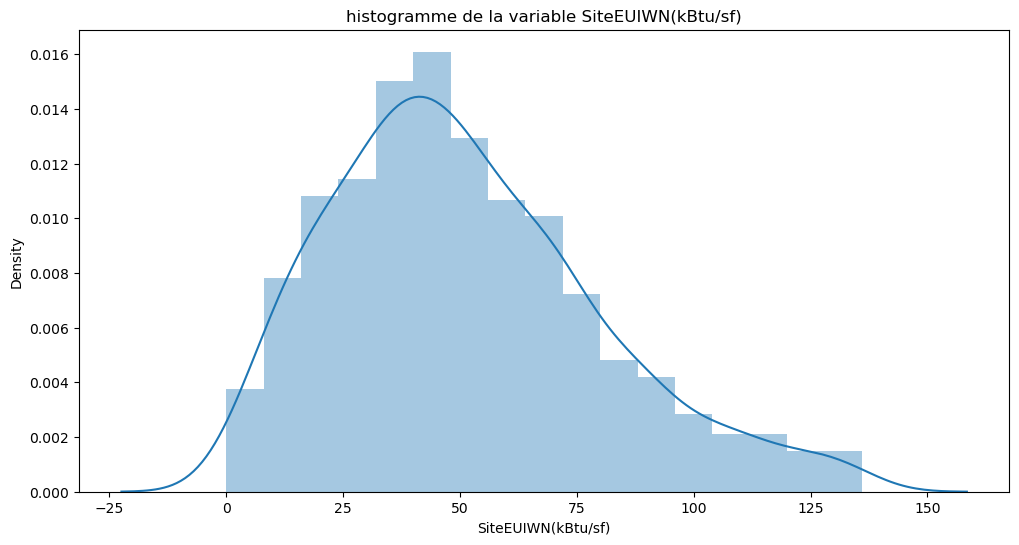

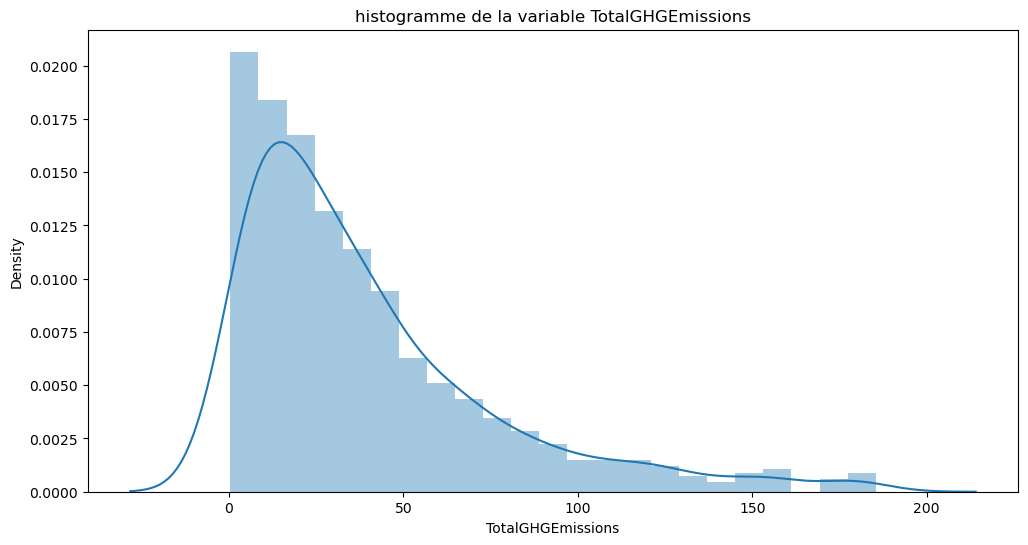

In [141]:
for col in df.select_dtypes(['int64', 'float64']):
    plt.figure(figsize=(12,6))
    sns.distplot(df[col]).set_title("histogramme de la variable " +col)

In [142]:
colonnes_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()
colonnes_categorielles = df.select_dtypes(include=[object]).columns.tolist()

print("Colonnes numériques:", colonnes_numeriques)
print("Colonnes catégorielles:", colonnes_categorielles)

Colonnes numériques: ['Latitude', 'Longitude', 'Agebuilding', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions']
Colonnes catégorielles: ['LargestPropertyUseType']


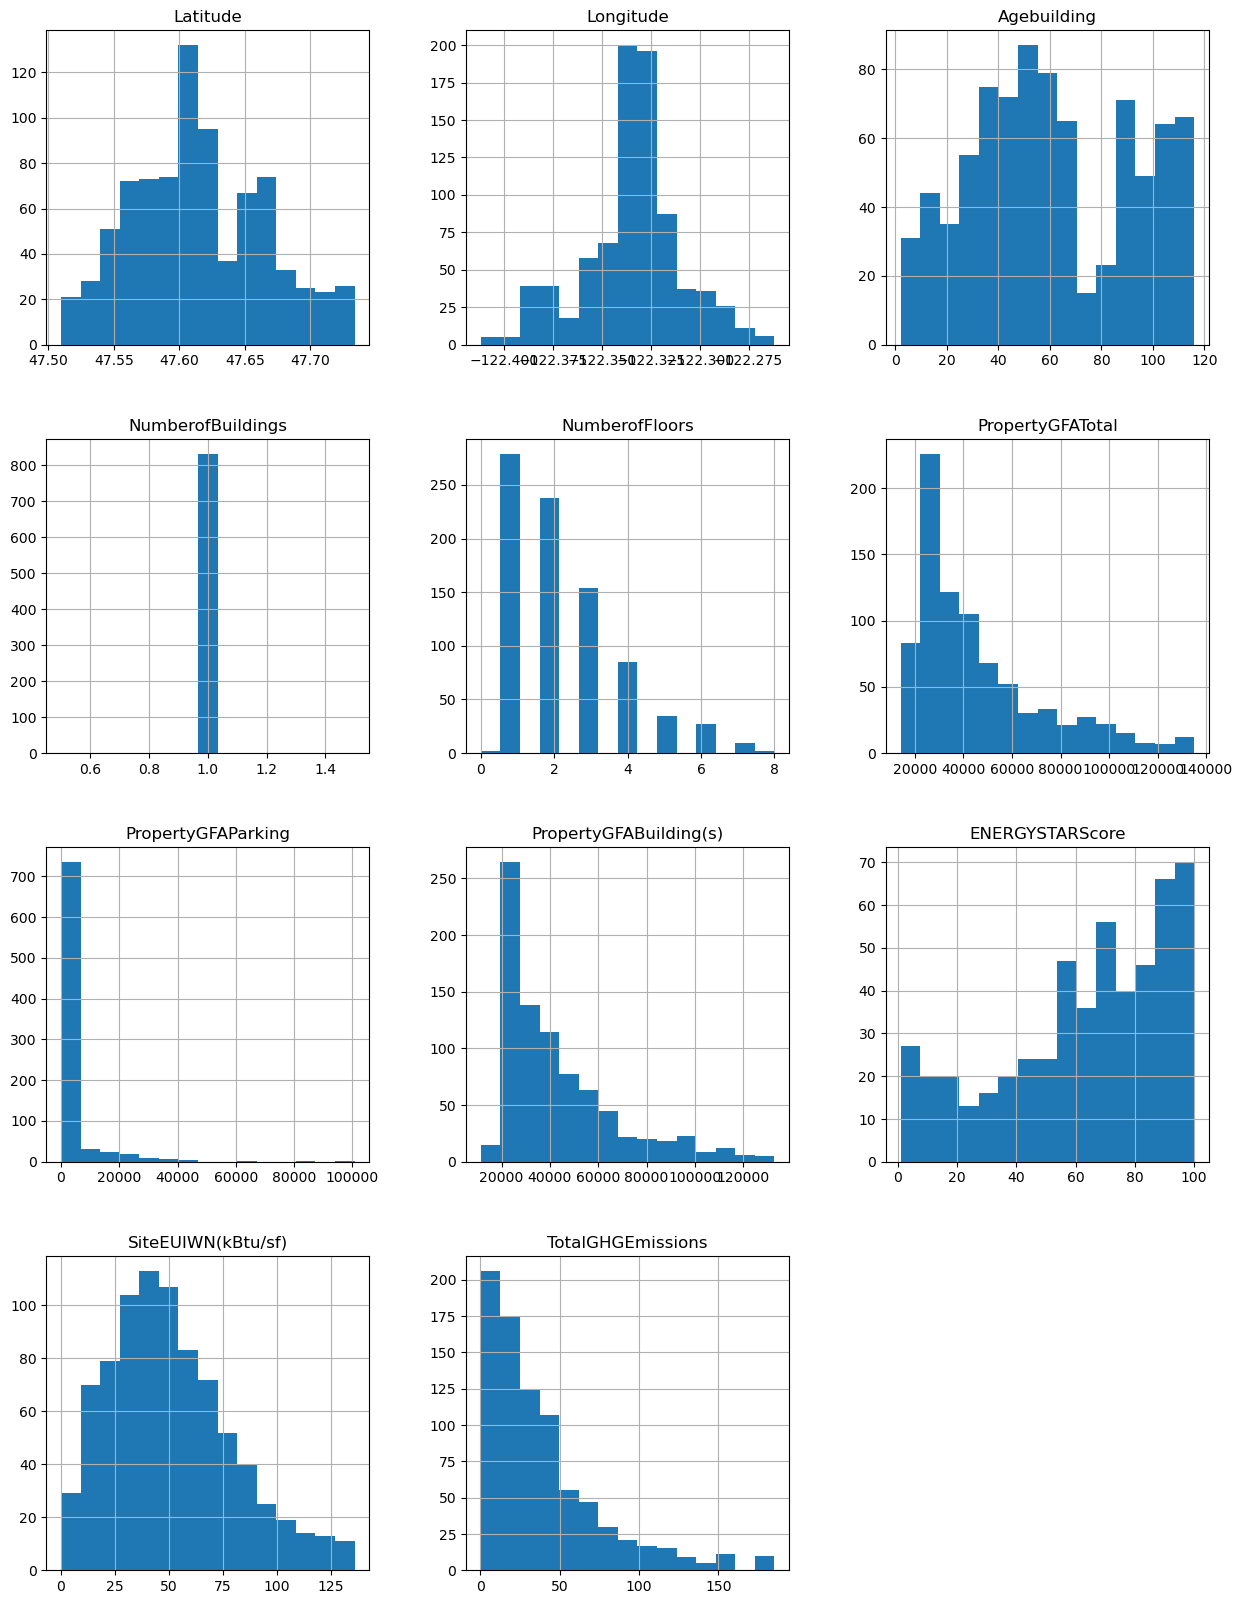

In [143]:
df[colonnes_numeriques].hist(bins=15, figsize=(15, 20))
plt.show()

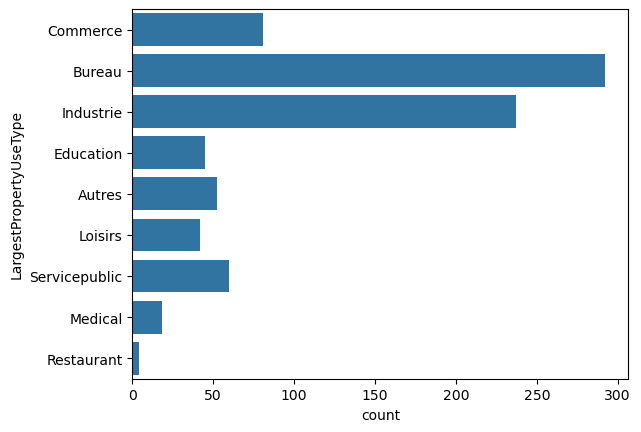

In [144]:
for col in colonnes_categorielles:
    sns.countplot(y=col, data=df)
    plt.show()

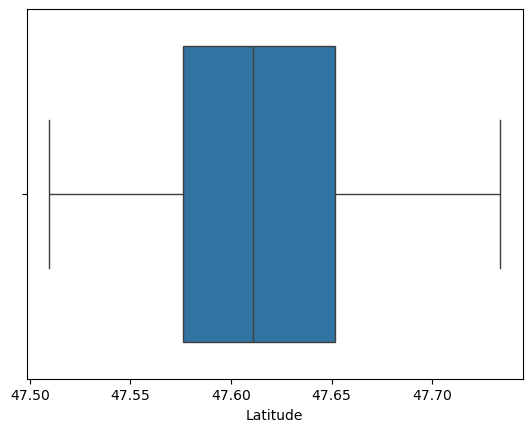

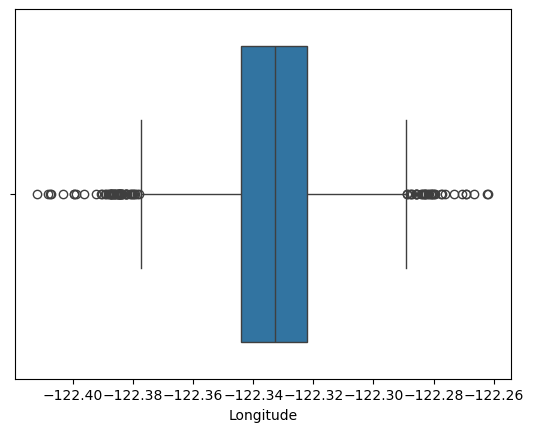

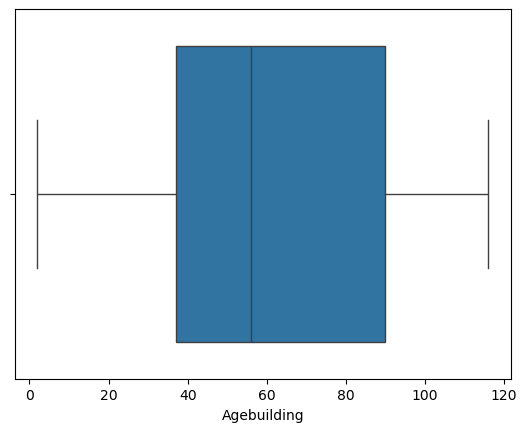

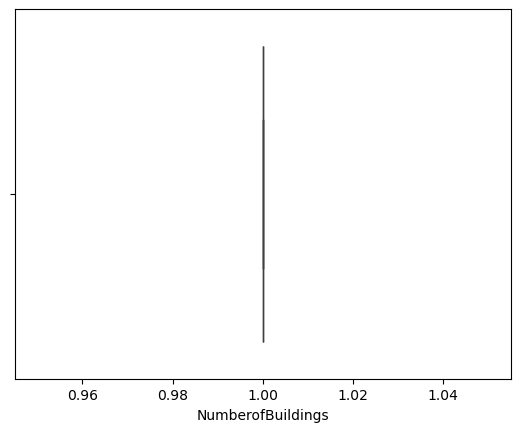

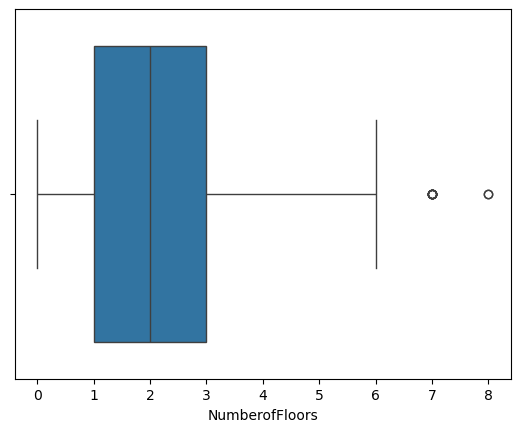

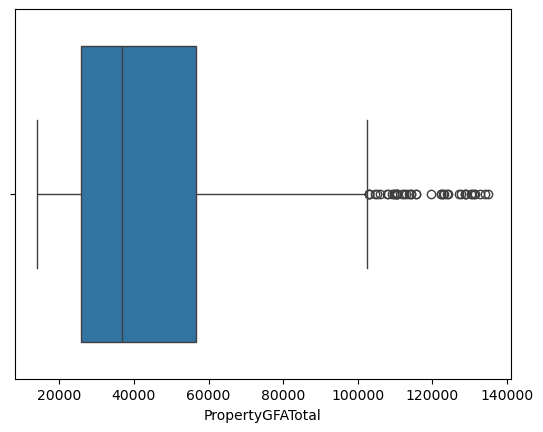

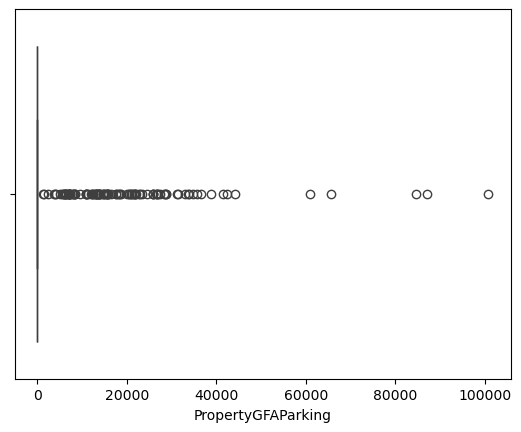

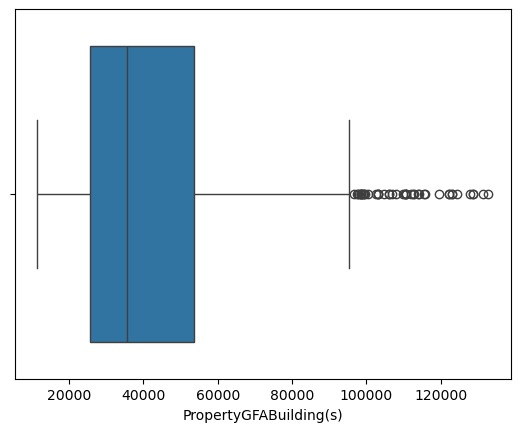

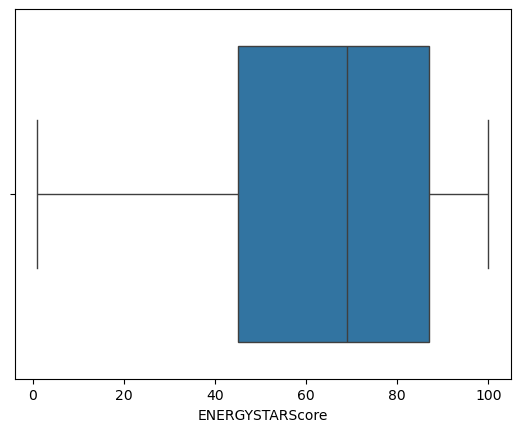

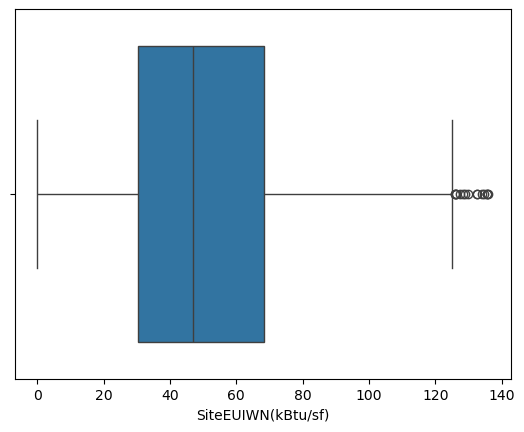

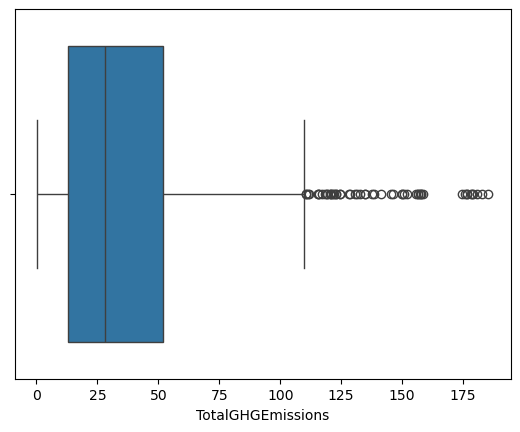

In [145]:
for col in colonnes_numeriques:
    sns.boxplot(x=df[col])
    plt.show()

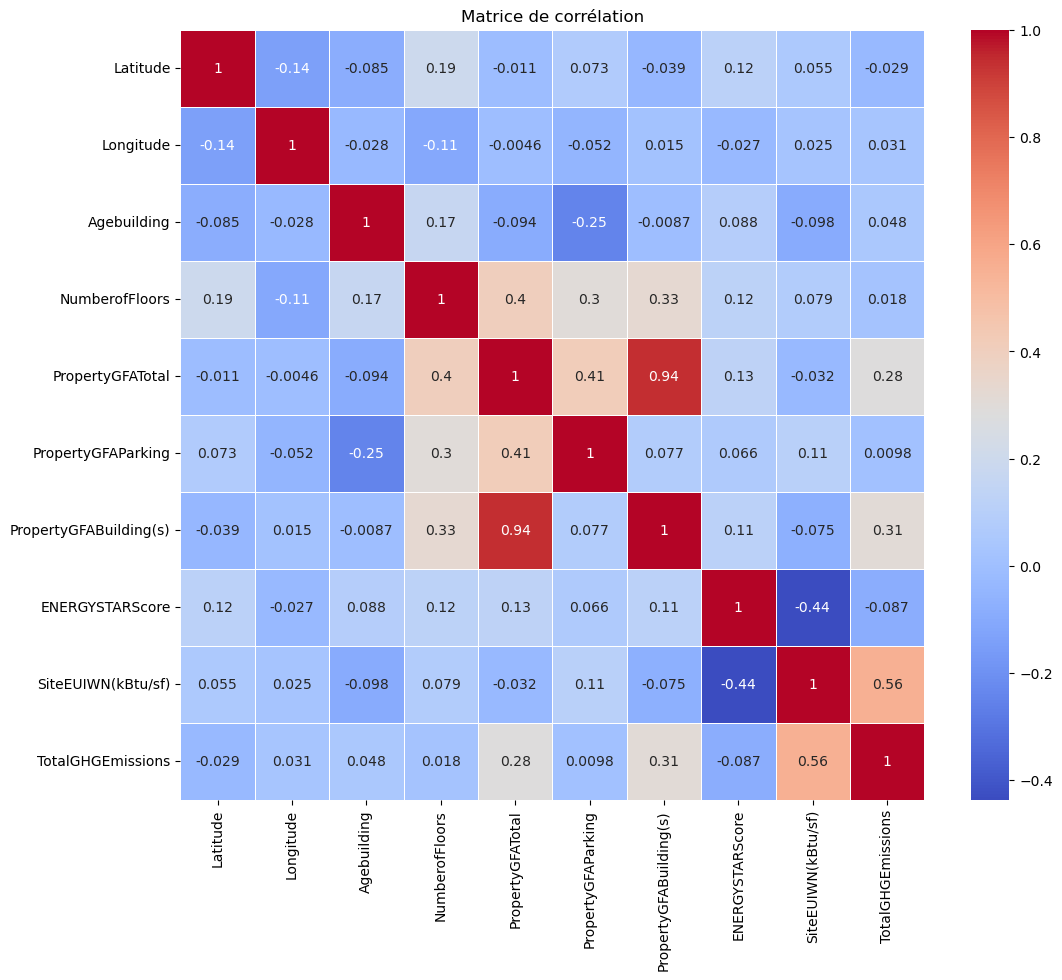

In [146]:
numeric_df = df.select_dtypes(include=['number'])

numeric_df = numeric_df.drop(columns=['NumberofBuildings'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

### Enregistrement data frame Final

In [147]:
df_final = df.copy()

In [148]:
df_final.to_csv('df_final.csv', index=False)